# Data & Figures for Grey-Loading Paper

## Imports and initialization

In [41]:
day = '1'
month = 'January'
year = '1900'
from CalibrationModules import D1_DacToFreq, TweezerPowerToDepth, MOT_DacToFreq
import numpy as np
from numpy import array as arr
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import style
from matplotlib import ticker
#from fitters import gaussian
import mpl_toolkits.axes_grid1 as axesTool
%matplotlib inline
style.use(['default'])
import matplotlib as mpl
import math
import scipy.optimize as opt
import os, sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from ExpFile import setPath
import ExpFile as exp
#from VersionManagement import getVersions
import PlotlyPlotters as pp
import MatplotlibPlotters as mp
import MainAnalysis as ma
import AnalysisHelpers as ah
import Miscellaneous as misc
import MarksConstants as mc
from importlib import reload
def reloadMyModules():
    reload(exp)
    setPath(day,month,year)
    reload(misc)
    reload(ma)
    reload(ah)
    reload(pp)
    reload(mp)
reloadMyModules()
paper_Font_Size=12
grey_mol_file = 'Grey_Molasses_Loading.h5'
alt_grey_mol_file = 'Alt_Grey_Molasses_Loading.h5'
red_optimum_file = 'Single_Atom_Red_Optimized.h5'
red_pgc_file = 'Red_Pgc_Loading.h5'
grey_mol_file_10x10 = '10x10_Grey_Molasses_Loading.h5'
single_optimum_file = 'Single_Atom_Optimized.h5'
rerng_exp_file = 'Rerng_6x6_Paper.h5'
rerng_moves_record = 'Rearranging_Move_Record_Paper.txt'

In [42]:
from statsmodels.stats.proportion import proportion_confint as confidenceInterval
def jeffreyInterval(m,num):
    print(round(m*num),end='')
    i1, i2 = confidenceInterval(round(m*num), num, method='jeffreys', alpha=1-0.6827)
    return (m - i1, i2 - m)

In [43]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [44]:
from fitters import linear

# used for single atom grey and red loading scans
def single_atom_analysis(file, title, units = None, showVals = False, realsize=False, save=False, key=None, data=None, err=None, textColor='k'):
    if file is not None:
        res = ma.standardPopulationAnalysis( file, [[2,2]], 0, 1, quiet=True );
        ( _, _, _, key, avgLoadingErr, avgLoading, _, _, _, _, _, _, _, _, _, _, _, _ ) = res
        avgLoading = avgLoading[0]
        avgLoadingErr = avgLoadingErr[0]
    else:
        avgLoading = data
        avgLoadingErr = err
    key1, key2 = key[:,0], key[:,1]
    key1 = np.sort(np.unique(key1))
    key2 = np.sort(np.unique(key2))
    im_2dscan = np.zeros((len(key1),len(key2)))
    f = plt.figure(figsize=(10,10))
    
    if realsize:
        f.set_size_inches(4.25, 4.25)
    for i, keyVal in enumerate(key):
        i1 = np.where(key1==keyVal[0])[0][0]
        i2 = np.where(key2==keyVal[1])[0][0]
        im_2dscan[i2,i1] = avgLoading[i]
        if showVals:
            plt.text(i1-0.5, i2+0.25, misc.round_sig(avgLoading[i],2), fontsize=6, color='g')
            plt.text(i1-0.5, i2-0.25, misc.round_sig(avgLoadingErr[i],2), fontsize=6, color='g')
    im = plt.imshow(im_2dscan, cmap='inferno', vmin=0, vmax=1, zorder=1)
    if units == "red":
        # this is MHz per mK, need to convert to vertical pixel per horizontal pixel (vp per hp)
        slope = 20.8 + 9.86
        mhzKey = [misc.round_sig(MOT_DacToFreq.f(k)/1e6) for k in key1]
        powKey = [misc.round_sig(TweezerPowerToDepth.f(k)) for k in key2]
        # mult by hp per Mhz get hp per mk
        slope *= 1 / (mhzKey[1] - mhzKey[0])
        # mult by mk per vp, get hp per vp
        slope *= (powKey[1] - powKey[0])
        # invert to get vp per hp, rise over run
        slope = slope**-1
        # the 0 intercept
        xintercept_ = - mhzKey[0] / (mhzKey[1] - mhzKey[0])
        yint_ = -xintercept * slope
        
        print(xintercept, '\n', mhzKey)
        xpts = np.linspace(-1, len(key1), 1000)
        plt.plot(xpts, linear.f(xpts, slope, yint), color='r', zorder=2 )
    if units == "grey":
        # this is MHz per mK, need to convert to vertical pixel per horizontal pixel (vp per hp)
        slope = 20.8 + 12.0
        slopeDepthDetuned = 2 * 20.8 + 12.0
        mhzKey = [misc.round_sig(D1_DacToFreq.f(k)) for k in key1]
        powKey = [misc.round_sig(TweezerPowerToDepth.f(k)) for k in key2]
        xintercept = - mhzKey[0] / (mhzKey[1] - mhzKey[0])
        print(xintercept, '\n', mhzKey)
        # mult by hp per Mhz get hp per mk
        slope *= 1 / (mhzKey[1] - mhzKey[0])
        slopeDepthDetuned *= 1 / (mhzKey[1] - mhzKey[0])
        # mult by mk per vp, get hp per vp
        slope *= (powKey[1] - powKey[0])
        slopeDepthDetuned *= (powKey[1] - powKey[0])
        # invert to get vp per hp, rise over run
        slope = slope**-1
        slopeDepthDetuned = slopeDepthDetuned**-1
        yint = -xintercept * slope
        yint2 = -xintercept * slopeDepthDetuned    
        xpts = np.linspace(-1, len(key1), 1000)
        plt.plot(xpts, linear.f(xpts, slope, yint), color='r', zorder=2 )
        plt.plot(xpts, linear.f(xpts, slopeDepthDetuned, yint2), color='b', zorder=2 )


    plt.grid(False)
    plt.xlabel('Cooling-Beam Frequency \n(MHz, Relative to Free-space resonance)')
    plt.ylabel('Trap Depth (mK)')
    if units is None:
        plt.xticks(range(0,len(key1),2), [misc.round_sig(k) for k in key1[::2]] , rotation=50,color=textColor)
        plt.yticks(range(0,len(key2),2), [misc.round_sig(k) for k in key2[::2]] , color=textColor)
    elif units == "red":
        plt.xticks(range(0,len(key1),2), [misc.round_sig(MOT_DacToFreq.f(k)*1e-6) for k in key1[::2]],rotation=25, color=textColor);
        plt.yticks(range(0,len(key2),2), [misc.round_sig(TweezerPowerToDepth.f(k)) for k in key2[::2]], color=textColor);
    elif units == "grey":
        plt.xticks(range(0,len(key1),2), [misc.round_sig(D1_DacToFreq.f(k)) for k in key1[::2]],rotation=25, color=textColor);
        plt.yticks(range(0,len(key2),2), [misc.round_sig(TweezerPowerToDepth.f(k)) for k in key2[::2]], color=textColor);
    plt.xlim(-0.5,21.5)
    plt.ylim(21.5,-0.5);
    divider = axesTool.make_axes_locatable(plt.gca())
    cax = divider.append_axes('right', size='5%', pad=0.0)
    cb = f.colorbar(im, cax, orientation='vertical');
    cb.ax.set_ylabel('Loading %', fontsize=paper_Font_Size, color=textColor)
    plt.title(title, color=textColor)
    for sp in gca().spines:
        gca().spines[sp].set_color(textColor)

    if save:
        plt.savefig(title + '.png', transparent=True, bbox_inches='tight', pad_inches=0.1, dpi=400)


In [5]:
# used for single atom grey and red loading scans
def single_atom_analysis_(file, title, units = None, showVals = False, realsize=False, save=False, key=None, data=None, err=None, textColor='k', fileExt = '.png'):
    if file is not None:
        res = ma.standardPopulationAnalysis( file, [[2,2]], 0, 1, quiet=True );
        ( _, _, _, key, avgLoadingErr, avgLoading, _, _, _, _, _, _, _, _, _, _,_,_ ) = res
        avgLoading = avgLoading[0]
        avgLoadingErr = avgLoadingErr[0]
    else:
        avgLoading = data
        avgLoadingErr = err
    key1, key2 = key[:,0], key[:,1]
    key1 = np.sort(np.unique(key1))
    key2 = np.sort(np.unique(key2))
    im_2dscan = np.zeros((len(key1),len(key2)))
    f = plt.figure(figsize=(10,10))
    if realsize:
        f.set_size_inches(4.25, 4.25)
    grid = axesTool.AxesGrid( f, 111, nrows_ncols=(1, 1), axes_pad=0.0, share_all=True,
                              label_mode="L", cbar_location="right", cbar_mode="single" )
    ax = grid[0]
    if units is None:
        xKey = [misc.round_sig(k) for k in key1]
        yKey = [misc.round_sig(k) for k in key2]
    elif units == "red":
        xKey = [misc.round_sig(MOT_DacToFreq.f(k)*1e-6) for k in key1]
        yKey = [misc.round_sig(TweezerPowerToDepth.f(k)) for k in key2]
    elif units == "grey":
        xKey = [misc.round_sig(D1_DacToFreq.f(k)) for k in key1]
        yKey = [misc.round_sig(TweezerPowerToDepth.f(k)) for k in key2]

    for i, keyVal in enumerate(key):
        i1 = np.where(key1==keyVal[0])[0][0]
        i2 = np.where(key2==keyVal[1])[0][0]
        im_2dscan[i2,i1] = avgLoading[i]
        if showVals:
            ax.text(xKey[i1], yKey[i2], misc.round_sig(avgLoading[i],2), fontsize=6, color='g')
            #ax.text(i1-0.5, i2-0.25, misc.round_sig(avgLoadingErr[i],2), fontsize=6, color='g')
                
    im = ax.imshow( im_2dscan, cmap='inferno', vmin=0, vmax=1, zorder=1,
                    extent = [xKey[0],xKey[-1], yKey[-1],yKey[0]], aspect=(xKey[-1]-xKey[0])/(yKey[-1]-yKey[0]))
    ax.tick_params(axis='x', colors=textColor)
    ax.tick_params(axis='y', colors=textColor)
    if units == "red":
        # this is MHz per mK, need to convert to vertical pixel per horizontal pixel (vp per hp)
        slope = 1 /( 20.8 + 9.86)
        xpts = np.linspace(xKey[0], xKey[-1], 1000)
        ax.plot(xpts, linear.f(xpts, slope, 0), color='r', zorder=2 )
    if units == "grey":
        # this is MHz per mK, need to convert to vertical pixel per horizontal pixel (vp per hp)
        slope = 1/(20.8 + 12.0)
        slopeDepthDetuned = 1/(3 * 20.8 + 12.0)
        xpts = np.linspace(xKey[0], xKey[-1], 1000)
        ax.plot(xpts, linear.f(xpts, slope, 0), color='g', zorder=2 )
        ax.plot(xpts, linear.f(xpts, slopeDepthDetuned, 0), color='b', zorder=2 )
        ax.axhline(yKey[7],color='#303030',dashes=[3,1])

    plt.grid(False)
    ax.set_xlabel('Cooling-Beam Frequency \n(MHz, Relative to Free-space resonance)', color=textColor)
    ax.set_ylabel('Trap Depth (mK)', color=textColor)
    f.set_facecolor('#00000000')
    ax.set_xlim(xKey[0], xKey[-1])
    ax.set_ylim(yKey[-1],yKey[0]);
    for sp in plt.gca().spines:
        plt.gca().spines[sp].set_color(textColor)
    #plt.gca().tick_params(axis='x', colors=textColor)
    #plt.gca().tick_params(axis='y', colors=textColor)
    cb = grid.cbar_axes[0].colorbar(im);
    axis = grid.cbar_axes[0].axis['right']
    axis.label.set_text("Loading %")
    axis.label.set_color(textColor)
    for sp in plt.gca().spines:
        plt.gca().spines[sp].set_color(textColor)
    plt.gca().tick_params(axis='y', colors=textColor)
    if save:
        plt.savefig(title + fileExt, transparent=True, bbox_inches='tight', pad_inches=0.1, dpi=800)


In [6]:
import imageio
import numpy as np
from numpy import array as arr
import matplotlib as mpl
import matplotlib.cm
from IPython.display import Image, HTML, display

infernoMap = [mpl.cm.inferno(i)[:-1] for i in range(256)]
viridisMap = [mpl.cm.viridis(i)[:-1] for i in range(256)]
magmaMap = [mpl.cm.magma(i)[:-1] for i in range(256)]
hotMap = [mpl.cm.hot(i)[:-1] for i in range(256)]
cividisMap = [mpl.cm.cividis(i)[:-1] for i in range(256)]
def makeVid(pics, gifAddress, videoType, fileAddress=None, dur=1, lim=None, includeCount=True, lowLim=None, 
            finLabels=[], finTxt="Atom Reservoir Depleted", vidMap=infernoMap, maxMult=1, offset=0,
            resolutionMult=1):
    # global count
    # select subsection
    if lim is None:
        lim = len(pics)
    if lowLim is None:
        lowLim = 0
    pics = pics[lowLim:lim]
    # normalize to rgb scale
    pics = pics - min(pics.flatten())
    pics = np.uint16(pics / max(pics.flatten()) * 256 * maxMult)
    pics = arr([[[int(elem) for elem in row] for row in pic] for pic in pics])
    pics = arr(pics-min(pics.flatten()) - offset)
    pics = [[[vidMap[elem] if elem < 256 and elem >= 0 else vidMap[255] if elem >= 256 else vidMap[0] 
              for elem in row] for row in pic] for pic in pics]
    images = []
    sequenceCount = 1
    offset = 0
    for picCount, pic in enumerate(pics):
        fig = plt.figure()
        fig.set_size_inches([9,9])
        ax = plt.Axes(fig, [0., 0., 1., 1.])
        ax.set_axis_off()
        fig.add_axes(ax)
        plt.grid(False)
        ax.imshow(pic, aspect='equal')
        if includeCount:
            ax.text(-0.1, 0.1, str(picCount+1-offset), color='white', fontsize=40)
        if picCount+1 in finLabels:
            ax.text(1.5, 14, finTxt, color='r', fontsize=40)
        name = "temp"+str(picCount+1)+".png"
        plt.savefig(name)
        images.append(imageio.imread(name))
        if picCount+1 in finLabels:
            sequenceCount += 1
            offset = picCount+1
            for _ in range(4):
                images.append(imageio.imread(name))
        plt.close('all')
    # make bigger
    pics = [np.repeat(np.repeat(pic, resolutionMult, axis=0), resolutionMult, axis=1) for pic in pics]
    imageio.mimsave(gifAddress, images, format=videoType, duration=dur)

# Rearranging Picture

In [11]:
reloadMyModules()

Number of Pictures: 10000
Picture Dimensions: 25 x 23
Variaitons: 1
Repetitions: 5000
Experiment started at (H:M:S)  19:59:19:  on (Y-M-D) 2018-9-14


C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:785: OptimizeWarning:

Covariance of the parameters could not be estimated



5


..\MatplotlibPlotters.py:490: RuntimeWarning:

invalid value encountered in double_scalars



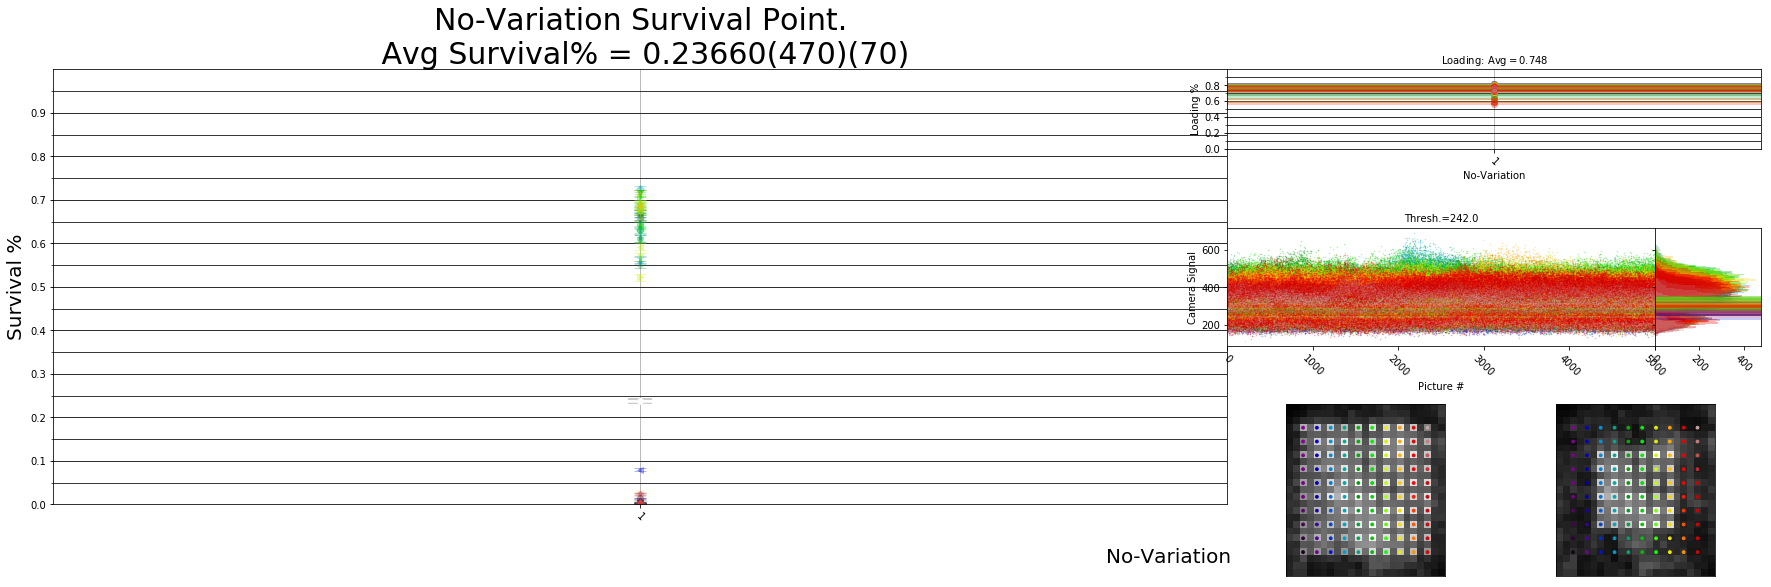

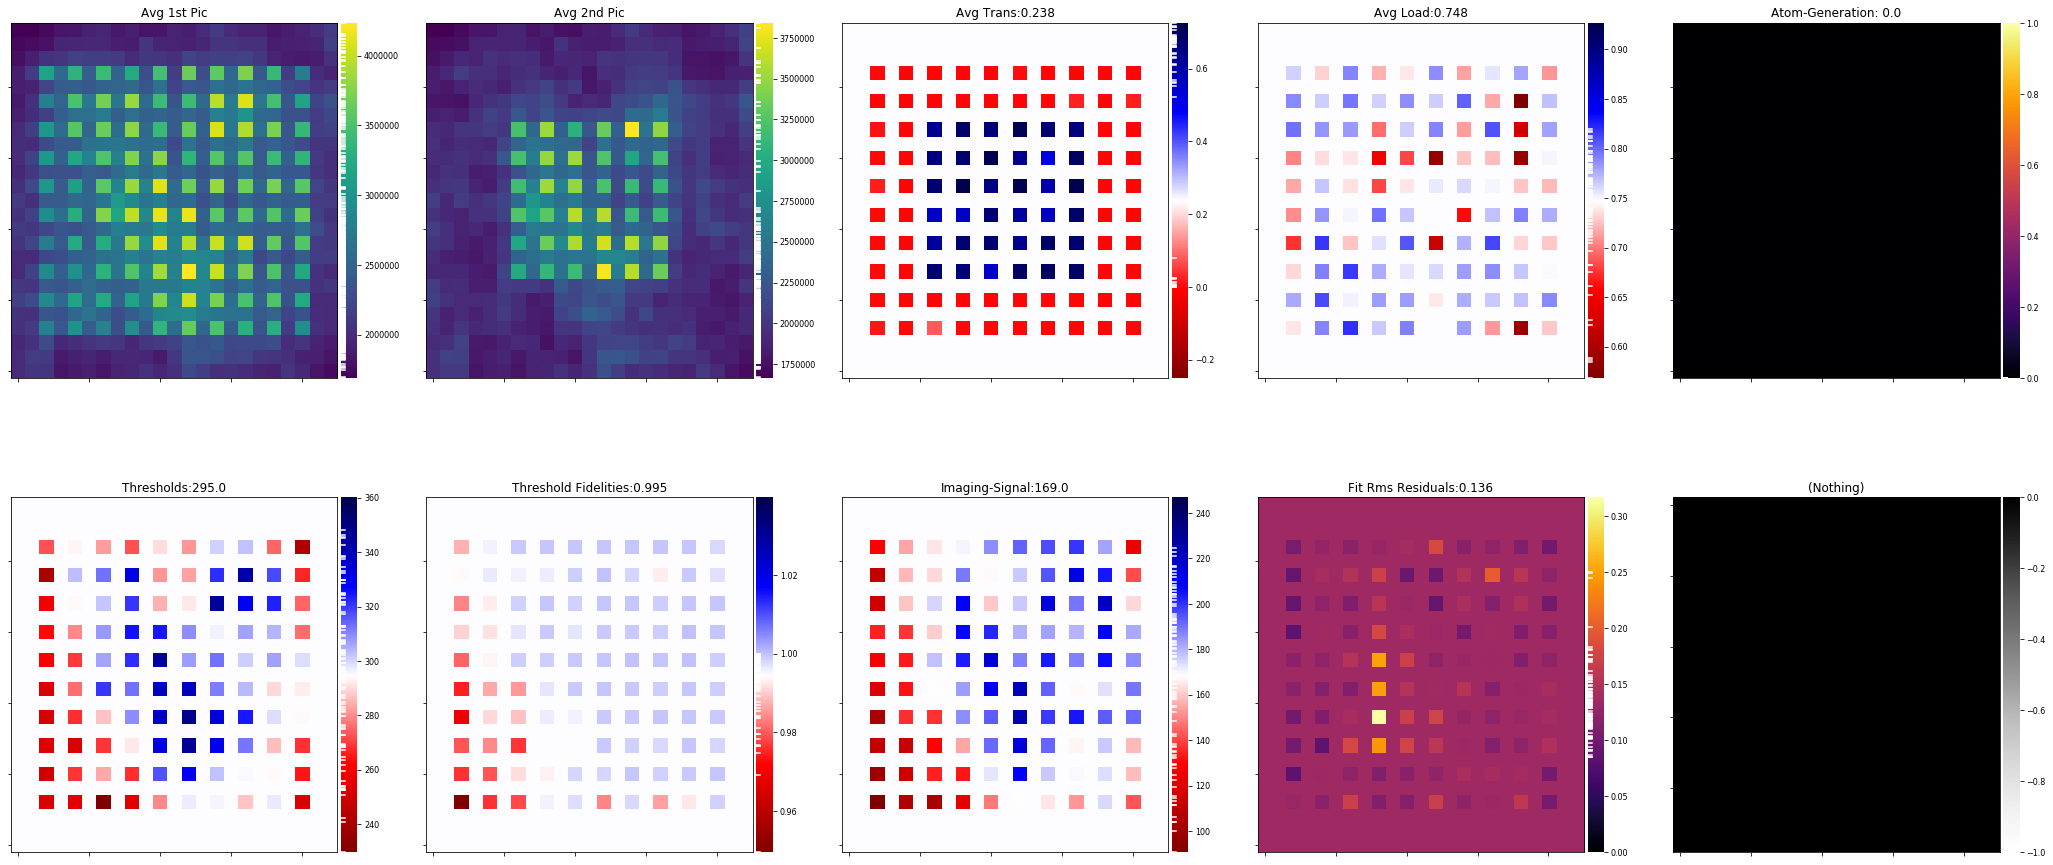

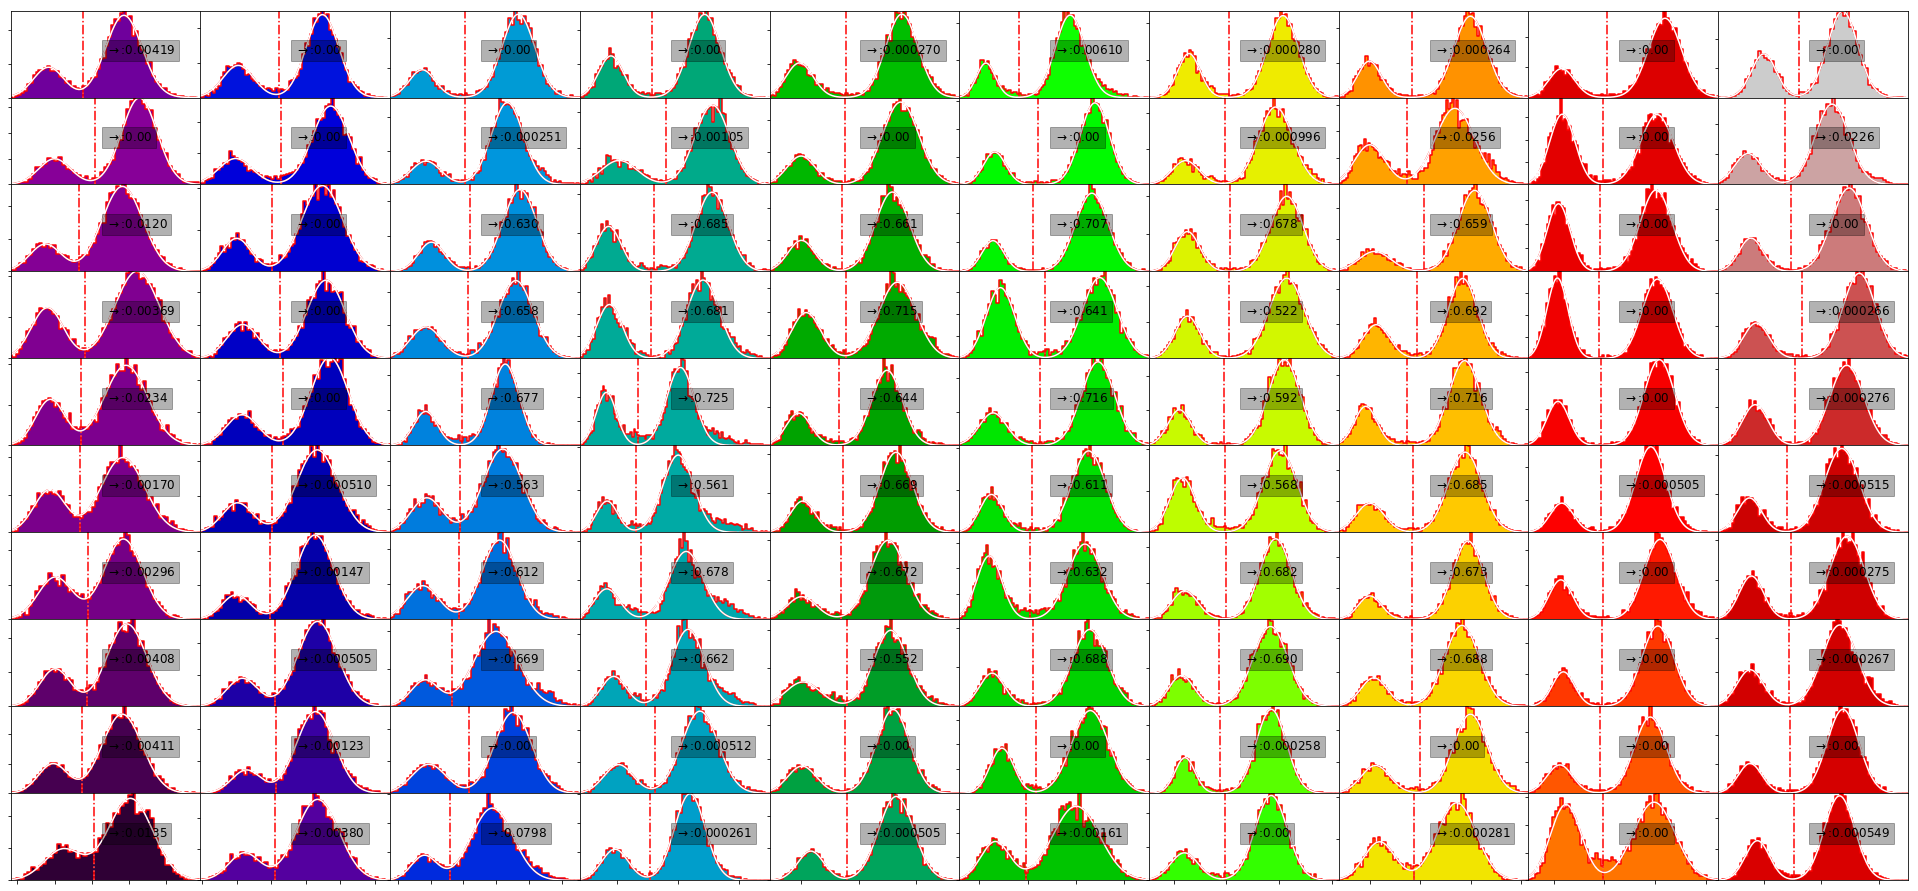

In [7]:
res = mp.Survival(rerng_exp_file, [3,2,2,10,10], subtractEdgeCounts=False, transThresholdSame=True, plotIndvHists=True);
( key, transferData, transferErrs, loadingRate, fits, avgFit, genAvgs, genErrs, pic1Data, 
  centers, avgTransferPic, transVarAvg, transVarErr, avgTransferData, avgTransferErr,
  loadAtomImages, transAtomImages, pic2Data, loadThresholds, transThresholds) = res

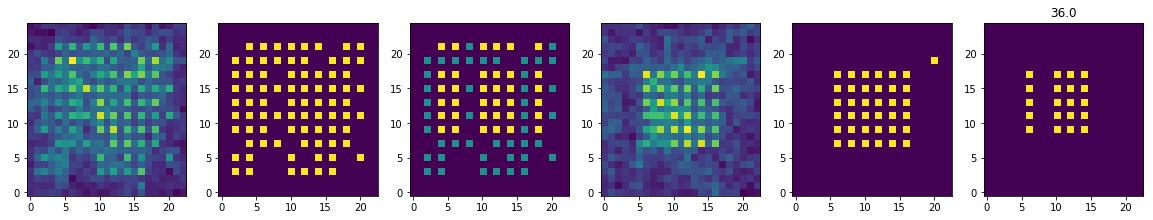

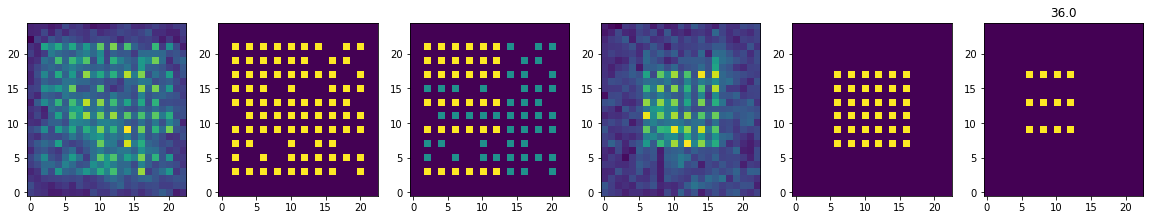

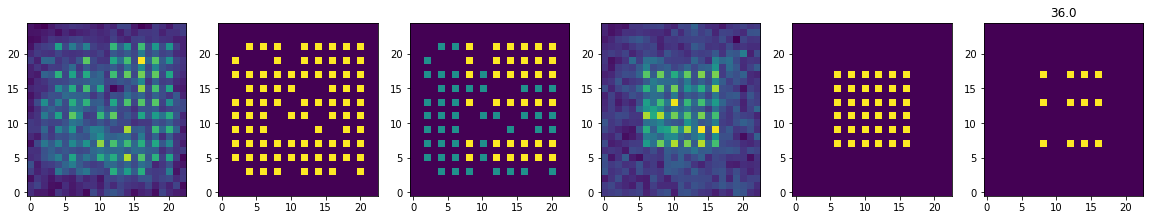

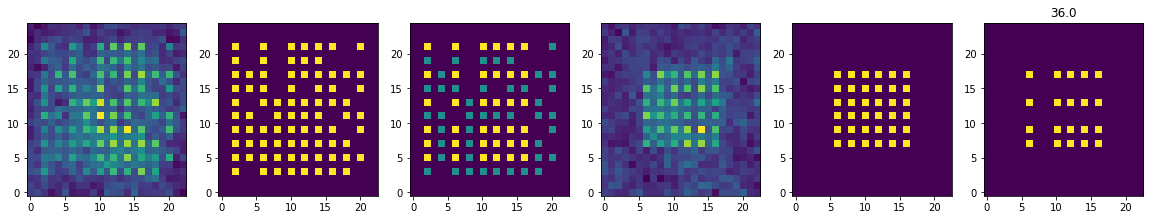

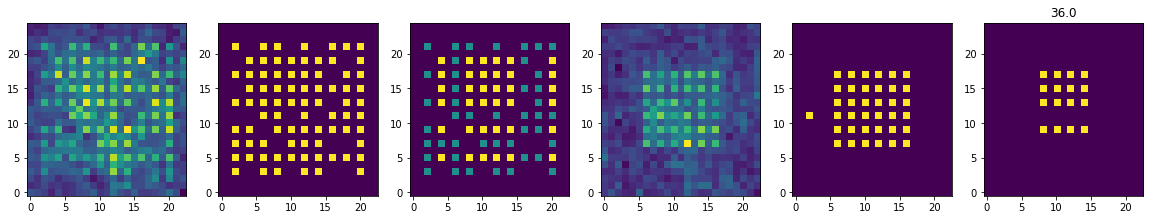

In [64]:
with exp.ExpFile(rerng_exp_file) as f:
    pics = f.get_pics()
count25 = 0
survivalList=[]
nomatch = 0
rerngSize = 6
finArray = np.zeros((25,23))
finlocs = ah.unpackAtomLocations([7,6,2,6,6])
for l in finlocs:
    finArray[l[0],l[1]] = 1
initPics36 = []
finPics36 = []
atomizedPics36 = []
finAtomized36 = []
initAtomized=[]
    
with open(rerng_moves_record) as f:
    for i, l in enumerate(f.readlines()[:]):
        if i < rerngSize+2:
            continue
        ln = i-rerngSize-2
        if ln % 4 == 0:
            continue
        if ln%4 == 1:
            expnum = int(int(ln)/4)
            sourceStr = l[7:-5]
            for x in [' ',';','\n']:
                sourceStr = sourceStr.replace(x,'')
            source = np.reshape([int(x) for x in sourceStr.split(',')],(10,10))
            sourcem = np.zeros((25,23)).astype(int)
            for i in range(10):
                for j in range(10):
                    if source[i,j]:
                        sourcem[2*i+3,2*j+2] = 1
        if ln%4 == 2:
            yind = [int(x) for x in l[:-3].split(',')]
        if ln%4 == 3:
            xind = [int(x) for x in l[:-3].split(',')]
            if yind == xind == [9,8,7,6,5,4]:
                nomatch += 1
                continue
            subm = np.zeros((25,23)).astype(int)
            for i in range(10):
                for j in range(10):
                    if i in yind and j in xind:
                        subm[2*i+3,2*j+2] = 1
            finNumAtoms = sum((transAtomImages[expnum] * finArray).flatten())
            survivalList.append(finNumAtoms)
            if (finNumAtoms >= 36):
                count25 += 1
                initPics36.append(pics[2*expnum])
                initAtomized.append(loadAtomImages[expnum])
                atomizedPics36.append(loadAtomImages[expnum] + subm)
                finAtomized36.append(transAtomImages[expnum])
                finPics36.append(pics[2*expnum+1])
                if True:
                    f, ax = plt.subplots(1,6, figsize=(20,20))
                    plt.title(finNumAtoms)
                    ax[0].imshow(pics[2*expnum], origin='bottom')
                    ax[1].imshow(loadAtomImages[expnum], origin='bottom')
                    ax[2].imshow(loadAtomImages[expnum] + subm, origin='bottom')
                    ax[3].imshow(pics[2*expnum+1], origin='bottom')
                    ax[4].imshow(transAtomImages[expnum], origin='bottom')
                    ax[5].imshow(transAtomImages[expnum] * subm, origin='bottom')
                    for a in ax:
                        a.grid(False)

In [65]:
for i in range(len(initPics36)):
    initPics36[i] = initPics36[i][2:23,1:22]
for i in range(len(finPics36)):
    finPics36[i] = finPics36[i][2:23,1:22]

### all first pic options

last pic is a bit less crucial maybe because less atoms so less chaotic

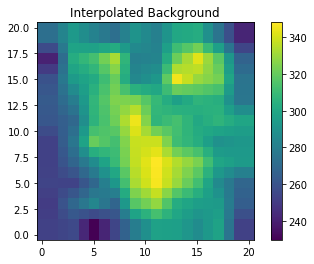

In [66]:
t_image = np.zeros(initPics36[0].shape)
# atoms
for i, loc in enumerate(ah.unpackAtomLocations([1,1,2,10,10])):
    t_image[loc[0],loc[1]] = loadThresholds[i].t
# between hor
for i, loc in enumerate(ah.unpackAtomLocations([2,1,2,10,9])):
    t_image[loc[0],loc[1]] = (t_image[loc[0]-1,loc[1]] + t_image[loc[0] + 1,loc[1]])/2
for i, loc in enumerate(ah.unpackAtomLocations([1,2,2,9,10])):
    t_image[loc[0],loc[1]] = (t_image[loc[0],loc[1]-1] + t_image[loc[0],loc[1]+1])/2
for i, l in enumerate(ah.unpackAtomLocations([2,2,2,9,9])):
    t_image[l[0],l[1]] = (t_image[l[0]-1,l[1]-1] + t_image[l[0]+1,l[1]+1]
                         +t_image[l[0]+1,l[1]-1] + t_image[l[0]-1,l[1]+1])/4

for r in range(21):
    t_image[r,0] = t_image[r,1]
    t_image[r,20] = t_image[r,19]
for c in range(21):
    t_image[0,c] = t_image[1,c]
    t_image[20,c] = t_image[19,c]
#t_image = t_image[2:23,1:22]
plt.imshow(t_image, origin='bottom')
plt.colorbar()
plt.title('Interpolated Background');


In [67]:
from fitters import double_gaussian

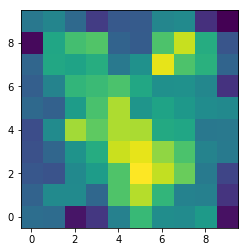

In [68]:
im = np.zeros((10,10))
for i, loc in enumerate(ah.unpackAtomLocations([0,0,1,10,10])):
    v=min([loadThresholds[i].fitVals[1], loadThresholds[i].fitVals[4]])
    im[loc[0],loc[1]] = v
plt.imshow(im, origin='bottom')

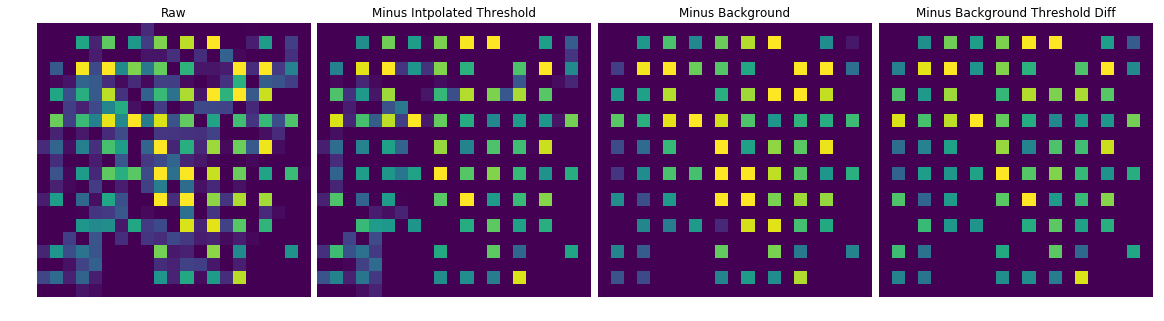

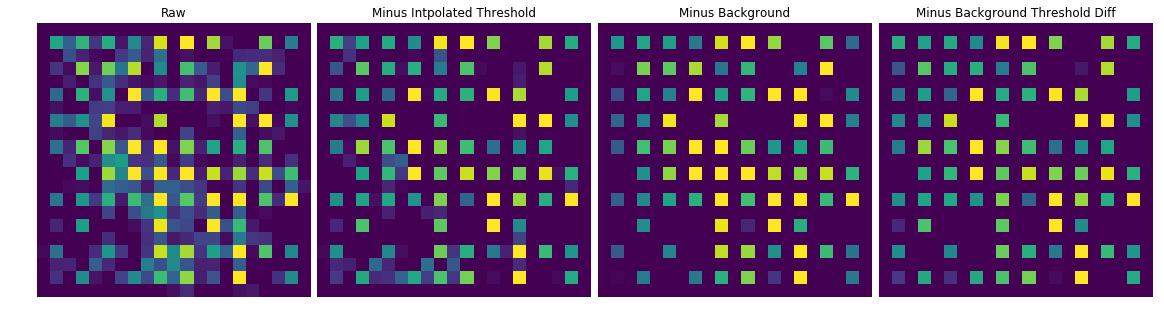

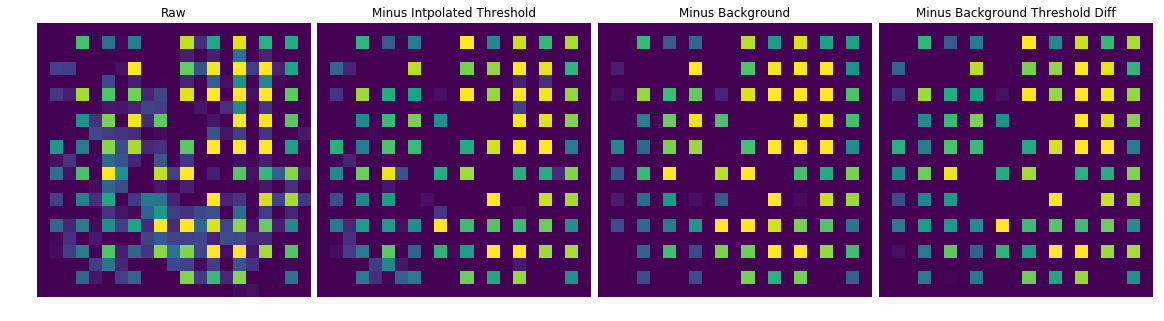

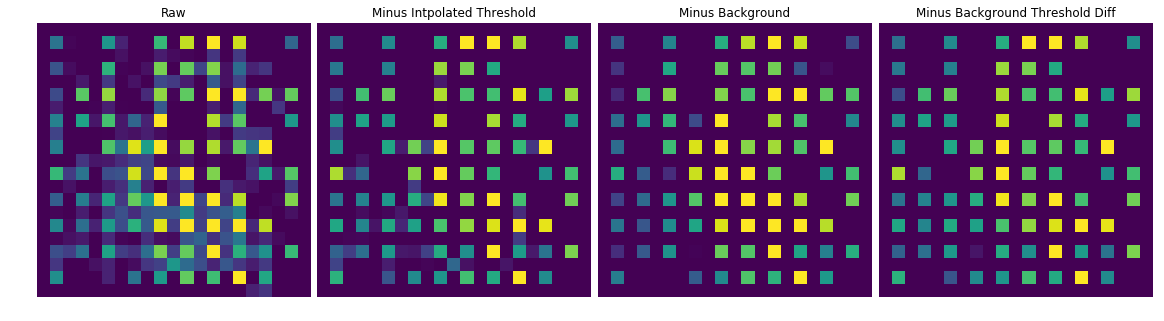

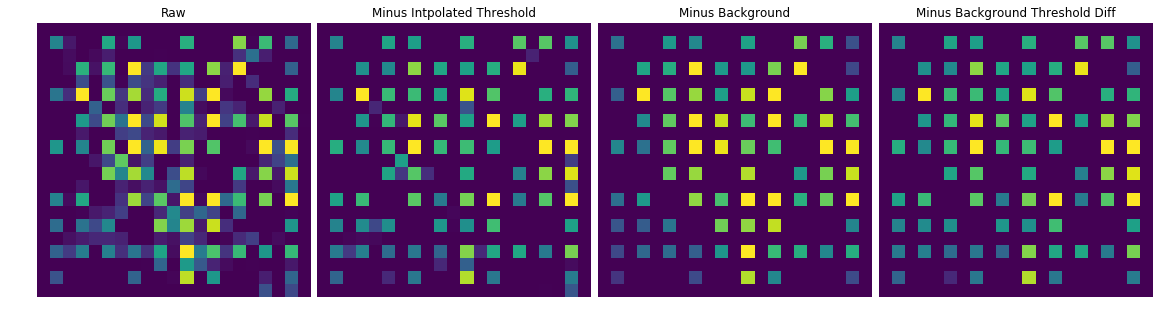

In [69]:
for which in range(5):
    args = [
        {'vmin':250, 'vmax':450, 'origin':'bottom'},
        {'vmin':0, 'vmax':150,'origin':'bottom'},
        {'vmin':275, 'vmax':450,'origin':'bottom'},
        {'vmin':0,  'vmax':150,'origin':'bottom'}
    ]
    showAtomBool = False
    cmap='viridis'
    fig = plt.figure(figsize=(20,10))
    grid = axesTool.AxesGrid( fig, 111, nrows_ncols=(1, 4), axes_pad=0.1, share_all=True)
    raw = initPics36[which]
    p = 0
    grid[p].axis('Off')
    grid[p].imshow(raw, **args[p],cmap=cmap)
    grid[p].set_title('Raw')
    subInterpBkgd = np.zeros(raw.shape)
    for loc in ah.unpackAtomLocations([0,0,1,21,21]):
        subInterpBkgd[loc[0],loc[1]] = raw[loc[0],loc[1]] - t_image[loc[0],loc[1]]
    if showAtomBool:
        for loc in ah.unpackAtomLocations([3,2,2,10,10]):
            color = 'b' if atomizedPics36[which][loc[0],loc[1]] else '#AA0000'
            grid[p].add_patch(plt.Rectangle((loc[1]-1.5, loc[0]-2.5),1,1, zorder=2, facecolor='none', edgecolor=color, 
                                       linewidth=1))
    p = 1
    grid[p].axis('Off')
    grid[p].imshow(subInterpBkgd, **args[p],cmap=cmap)
    grid[p].set_title('Minus Intpolated Threshold')
    
    mBkgd = np.zeros(raw.shape)
    for loc in ah.unpackAtomLocations([1,1,2,10,10]):
        mBkgd[loc[0],loc[1]] = raw[loc[0],loc[1]]
    if showAtomBool:
        for loc in ah.unpackAtomLocations([3,2,2,10,10]):
            color = 'b' if atomizedPics36[which][loc[0],loc[1]] else '#AA0000'
            grid[p].add_patch(plt.Rectangle((loc[1]-1.5, loc[0]-2.5),1,1, zorder=2, facecolor='none', edgecolor=color, 
                                       linewidth=1))
    p=2
    grid[p].axis('Off')
    grid[p].imshow(mBkgd, **args[p],cmap=cmap)
    grid[p].set_title('Minus Background')
    if showAtomBool:
        for loc in ah.unpackAtomLocations([3,2,2,10,10]):
            color = 'b' if atomizedPics36[which][loc[0],loc[1]] else '#AA0000'
            grid[p].add_patch(plt.Rectangle((loc[1]-1.5, loc[0]-2.5),1,1, zorder=2, facecolor='none', edgecolor=color, 
                                       linewidth=1))
    mBkgdThresh = np.zeros(raw.shape)
    p=3
    for loc in ah.unpackAtomLocations([1,1,2,10,10]):
        mBkgd[loc[0],loc[1]] = subInterpBkgd[loc[0],loc[1]]
    grid[p].axis('Off')
    grid[p].imshow(mBkgd, **args[p],cmap=cmap)
    grid[p].set_title('Minus Background Threshold Diff')
    if showAtomBool:
        for loc in ah.unpackAtomLocations([3,2,2,10,10]):
            color = 'b' if atomizedPics36[which][loc[0],loc[1]] else '#AA0000'
            grid[p].add_patch(plt.Rectangle((loc[1]-1.5, loc[0]-2.5),1,1, zorder=2, facecolor='none', edgecolor=color, 
                                       linewidth=1))


### Plain

In [ ]:
for which in range(5):
    fig = plt.figure(figsize=(40,20))
    grid = axesTool.AxesGrid( fig, 111, nrows_ncols=(1, 3), axes_pad=0.1, share_all=True)
    cmaps=['inferno', 'cividis', 'inferno']
    numAtoms = sum([bool(x) for y in atomizedPics36[which] for x in y])
    titles = ['Initial', 'Atomized-Selected', 'Final']
    #fig.set_size_inches([9,9])
    pics_ = [initPics36[which], atomizedPics36[which], finPics36[which]] # initAtomized
    mins = [None,0,None]
    maxs = [None,2,None]
    for i, (a, p, _min, _max, cm, t) in enumerate(zip(grid, pics_, mins, maxs, cmaps, titles)):
        a.imshow(p[1:24,:], origin='bottom', cmap=cm, vmin=_min, vmax=_max)
        a.set_xticks([])
        a.set_yticks([])
        a.grid(False)
        for loc in ah.unpackAtomLocations([3,2,2,10,10]):
            if i < 2:
                color = 'g' if atomizedPics36[which][loc[0],loc[1]] else '#AA0000'
                a.add_patch(plt.Rectangle((loc[1]-0.5, loc[0]-1.5),1,1, zorder=2, facecolor='none', edgecolor=color, 
                                      linewidth=2))
            else:
                color = 'g' if finAtomized36[which][loc[0],loc[1]] else '#AA0000'
                a.add_patch(plt.Rectangle((loc[1]-0.5, loc[0]-1.5),1,1, zorder=2, facecolor='none', edgecolor=color, 
                                      linewidth=2))
    #plt.savefig('Rerng_Sequence.png', transparent=True, bbox_inches='tight', pad_inches=0.1)

### Subtract bckgnd & diff from thresholds

In [ ]:
which = -1
fig = plt.figure(figsize=(40,20))
grid = axesTool.AxesGrid( fig, 111, nrows_ncols=(1, 3), axes_pad=0.15, share_all=True,
                          cbar_location="bottom", cbar_mode="each", cbar_size="7%", cbar_pad="0%" )
numAtoms = sum([bool(x) for y in atomizedPics36[which] for x in y])
fig.set_size_inches([12,12])
init_ = np.zeros(initPics36[0].shape)
for i, loc in enumerate(ah.unpackAtomLocations([3,2,2,10,10])):
    init_[loc[0],loc[1]] = initPics36[which][loc[0],loc[1]] - loadThresholds[i].t 
fin_ = np.zeros(finPics36[which].shape)
for i, loc in enumerate(ah.unpackAtomLocations([3,2,2,10,10])):
    v = finPics36[which][loc[0],loc[1]] - transThresholds[i].t
    fin_[loc[0],loc[1]] = v
    #if v > 0:
    #    print(loc, v, transThresholds[i].t, finPics36[which][loc[0],loc[1]])

# initAtomized
pics   = [init_, atomizedPics36[which], fin_] 
mins   = [0,0,0]
maxs   = [200,2,50]
cmaps  = ['viridis', mpl.cm.get_cmap('cividis',3), 'viridis']
titles = ['Initial', 'Atomized-Selected', 'Final']

for i, (a, p, _min, _max, cm, t) in enumerate(zip(grid, pics, mins, maxs, cmaps, titles)):
    im = a.imshow(p[1:24,:], origin='bottom', cmap=cm, vmin=_min, vmax=_max)
    a.set_xticks([])
    a.set_yticks([])
    a.grid(False)
    for loc in ah.unpackAtomLocations([3,2,2,10,10]):
        if i < 2:
            color = 'g' if atomizedPics36[which][loc[0],loc[1]] else '#AA0000'
            a.add_patch(plt.Rectangle((loc[1]-0.5, loc[0]-1.5),1,1, zorder=2, facecolor='none', edgecolor=color, 
                                  linewidth=1))
        else:
            color = '#505050'
            a.add_patch(plt.Rectangle((loc[1] - 0.5, loc[0]-1.5),1,1, zorder=2, facecolor='none', edgecolor=color, 
                                       linewidth=1 ))
    cb = grid.cbar_axes[i].colorbar(im)
    if i is 1:
        cb.ax.set_xticks([1/3,1,5/3])
        cb.ax.set_xticklabels(['Bkgd','Extra Atom','6x6 Atoms'], fontsize=12)
    else:
        cb.ax.set_xticks([_min,_max])
        cb.ax.set_xticklabels([_min,_max],fontsize=12)
#plt.savefig('Rerng_Sequence.png', transparent=True, bbox_inches='tight', pad_inches=0.1, dpi=400)

### subtract avg threshold from bckgnd & diff from threshold

In [ ]:
#for which in range(5):
which = -1
fig = plt.figure(figsize=(40,20))
grid = axesTool.AxesGrid( fig, 111, nrows_ncols=(1, 3), axes_pad=0.15, share_all=True,
                          cbar_location="bottom", cbar_mode="each", cbar_size="7%", cbar_pad="0%" )
numAtoms = sum([bool(x) for y in atomizedPics36[which] for x in y])
fig.set_size_inches([12,12])
init_ = np.zeros(initPics36[0].shape)
thresholdInc = 0
avgThresh = 0
for thresh in loadThresholds:
    avgThresh += thresh.t
avgThresh /= 100
for loc in ah.unpackAtomLocations([0,0,1,23,25]):
    if loc in ah.unpackAtomLocations([3,2,2,10,10]):
        init_[loc[0],loc[1]] = initPics36[which][loc[0],loc[1]] - loadThresholds[thresholdInc].t 
        thresholdInc += 1
    else:
        init_[loc[0],loc[1]] = initPics36[which][loc[0],loc[1]] - avgThresh
fin_ = np.zeros(finPics36[0].shape)
thresholdInc=0
for loc in ah.unpackAtomLocations([0,0,1,23,25]):
    if loc in ah.unpackAtomLocations([3,2,2,10,10]):
        fin_[loc[0],loc[1]] = finPics36[which][loc[0],loc[1]] - loadThresholds[thresholdInc].t 
        thresholdInc += 1
    else:
        fin_[loc[0],loc[1]] = finPics36[which][loc[0],loc[1]] - avgThresh
    #if v > 0:
    #    print(loc, v, transThresholds[i].t, finPics36[which][loc[0],loc[1]])

# initAtomized
pics   = [init_, atomizedPics36[which], fin_] 
mins   = [-40,0,-60]
maxs   = [150,2,140]
cmaps  = ['inferno', mpl.cm.get_cmap('cividis',3), 'inferno']
titles = ['Initial', 'Atomized-Selected', 'Final']

for i, (a, p, _min, _max, cm, t) in enumerate(zip(grid, pics, mins, maxs, cmaps, titles)):
    im = a.imshow(p[1:24,:], origin='bottom', cmap=cm, vmin=_min, vmax=_max)
    a.set_xticks([])
    a.set_yticks([])
    a.grid(False)
    for loc in ah.unpackAtomLocations([3,2,2,10,10]):
        if i < 2:
            color = 'g' if atomizedPics36[which][loc[0],loc[1]] else '#AA0000'
            a.add_patch(plt.Rectangle((loc[1]-0.5, loc[0]-1.5),1,1, zorder=2, facecolor='none', edgecolor=color, 
                                  linewidth=1))
        else:
            color = '#505050'
            a.add_patch(plt.Rectangle((loc[1] - 0.5, loc[0]-1.5),1,1, zorder=2, facecolor='none', edgecolor=color, 
                                       linewidth=1 ))
    cb = grid.cbar_axes[i].colorbar(im)
    continue
    if i is 1:
        cb.ax.set_xticks([1/3,1,5/3])
        cb.ax.set_xticklabels(['Bkgd','Extra Atom','6x6 Atoms'], fontsize=12)
    else:
        cb.ax.set_xticks([_min,_max])
        cb.ax.set_xticklabels([_min,_max],fontsize=12)
#plt.savefig('Rerng_Sequence.png', transparent=True, bbox_inches='tight', pad_inches=0.1, dpi=400)


### subtract nearby threshold from background

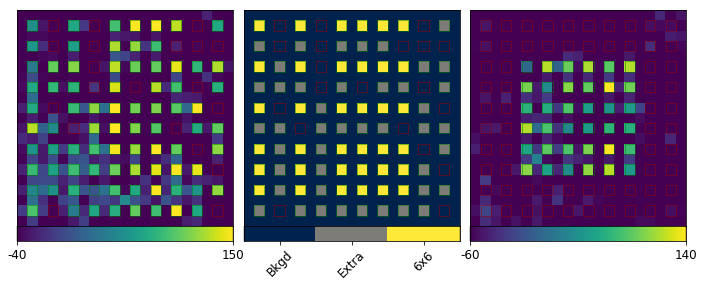

In [119]:
which = 3
fig = plt.figure(figsize=(40,20))
grid = axesTool.AxesGrid( fig, 111, nrows_ncols=(1, 3), axes_pad=0.15, share_all=True,
                          cbar_location="bottom", cbar_mode="each", cbar_size="7%", cbar_pad="0%" )
numAtoms = sum([bool(x) for y in atomizedPics36[which] for x in y])
fig.set_size_inches([20,4.25])
init_ = np.zeros((21,21))
thresholdInc = 0
avgThresh = 0
for thresh in loadThresholds:
    avgThresh += thresh.t
avgThresh /= 100
for loc in ah.unpackAtomLocations([0,0,1,21,21]):
    init_[loc[0],loc[1]] = initPics36[which][loc[0],loc[1]] - t_image[loc[0],loc[1]]
fin_ = np.zeros((21,21))
thresholdInc=0
for loc in ah.unpackAtomLocations([0,0,1,21,21]):
    init_[loc[0],loc[1]] = initPics36[which][loc[0],loc[1]] - t_image[loc[0],loc[1]]
for loc in ah.unpackAtomLocations([0,0,1,21,21]):
    fin_[loc[0],loc[1]] = finPics36[which][loc[0],loc[1]] - t_image[loc[0],loc[1]]

# initAtomized
pics   = [init_, atomizedPics36[which][2:23,1:22], fin_] 
mins   = [-40,0,-60]
maxs   = [150,2,140]
cmaps  = ['viridis', mpl.cm.get_cmap('cividis',3), 'viridis']
titles = ['Initial', 'Atomized-Selected', 'Final']

for i, (a, p, _min, _max, cm, t) in enumerate(zip(grid, pics, mins, maxs, cmaps, titles)):
    im = a.imshow(p, origin='bottom', cmap=cm, vmin=_min, vmax=_max)
    a.set_xticks([])
    a.set_yticks([])
    a.grid(False)
    for loc in ah.unpackAtomLocations([1,1,2,10,10]):
        if i < 2:
            color = 'g' if atomizedPics36[which][2:23,1:22][loc[0],loc[1]] else '#A00000'
            a.add_patch(plt.Rectangle((loc[1]-0.5, loc[0]-0.5),1,1, zorder=2, facecolor='none', edgecolor=color,linewidth=0.5))
        else:
            #color = '#505050'
            color = 'g' if finAtomized36[which][2:23,1:22][loc[0],loc[1]] else '#A00000'
            a.add_patch(plt.Rectangle((loc[1]-0.5, loc[0]-0.5),1,1, zorder=2, facecolor='none', edgecolor=color,linewidth=0.5))
    cb = grid.cbar_axes[i].colorbar(im)
    if i is 1:
        cb.ax.set_xticks([1/3,1,5/3])
        cb.ax.set_xticklabels(['Bkgd','Extra','6x6'], fontsize=12,rotation=45)
    else:
        cb.ax.set_xticks([_min,_max])
        cb.ax.set_xticklabels([_min,_max],fontsize=12)
plt.savefig('Rerng_Sequence.png', transparent=True, bbox_inches='tight', pad_inches=0, dpi=400)

### just subtract background

In [ ]:
for which in range(5):
    fig = plt.figure(figsize=(40,20))
    grid = axesTool.AxesGrid( fig, 111, nrows_ncols=(1, 3), axes_pad=0.1, share_all=True)
    cmaps=['viridis', 'cividis', 'viridis']
    numAtoms = sum([bool(x) for y in atomizedPics36[which] for x in y])
    titles = ['Initial', 'Atomized-Selected', 'Final']
    #fig.set_size_inches([9,9])
    init_ = np.zeros(initPics36[0].shape)
    for i, loc in enumerate(ah.unpackAtomLocations([3,2,2,10,10])):
        init_[loc[0],loc[1]] = initPics36[which][loc[0],loc[1]]# - loadThresholds[i].t  # loadThresholds, transThresholds
    fin_ = np.zeros(finPics36[which].shape)
    for loc in ah.unpackAtomLocations([3,2,2,10,10]):
        fin_[loc[0],loc[1]] = finPics36[which][loc[0],loc[1]]#- loadThresholds[i].t
    pics_ = [init_, atomizedPics36[which],fin_] # initAtomized
    mins = [250, 0, 275]
    maxs = [450, 2, 450]
    for i, (a, p, _min, _max, cm, t) in enumerate(zip(grid, pics_, mins, maxs, cmaps, titles)):
        a.imshow(p[1:24,:], origin='bottom', cmap=cm, vmin=_min, vmax=_max)
        a.set_xticks([])
        a.set_yticks([])
        a.grid(False)
        for loc in ah.unpackAtomLocations([3,2,2,10,10]):
            if i < 2:
                color = 'g' if atomizedPics36[which][loc[0],loc[1]] else '#AA0000'
                a.add_patch(plt.Rectangle((loc[1]-0.5, loc[0]-1.5),1,1, zorder=2, facecolor='none', edgecolor=color, 
                                      linewidth=2))
            else:
                color = 'g' if finAtomized36[which][loc[0],loc[1]] else '#AA0000'
                a.add_patch(plt.Rectangle((loc[1]-0.5, loc[0]-1.5),1,1, zorder=2, facecolor='none', edgecolor=color, 
                                      linewidth=2))
        #plt.savefig('rerng_sequence_'+str(i)+'.png', transparent=True, bbox_inches='tight', pad_inches=0.1, dpi=400)
    #plt.savefig('Rerng_Sequence.png', transparent=True, bbox_inches='tight', pad_inches=0.1)

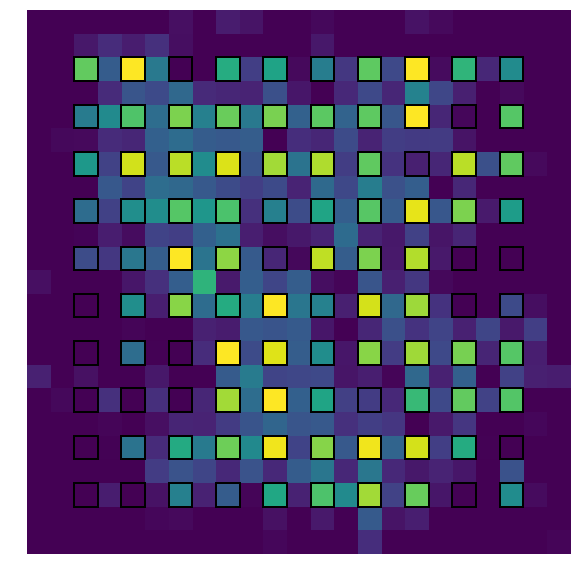

In [206]:
plt.figure(figsize=(10,10))
plt.imshow(rawData[5702][1:24,:], vmin=225, vmax=475, origin='bottom', cmap='viridis', zorder=1)

currentAxis = plt.gca()
for loc in ah.unpackAtomLocations([3,2,2,10,10]):
    currentAxis.add_patch(plt.Rectangle((loc[0]-1.5, loc[1]-0.5),1,1, zorder=2, facecolor='none', edgecolor='k', 
                                       linewidth=2))
plt.axis('off');
plt.savefig('80_Atoms.png', transparent=True, bbox_inches='tight', pad_inches=0.1)

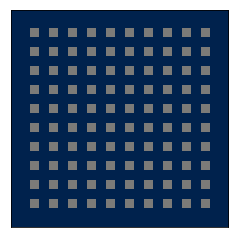

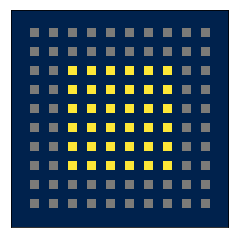

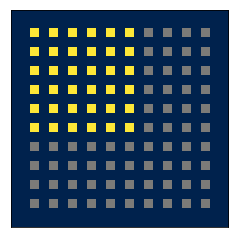

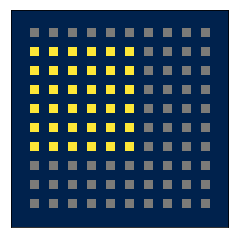

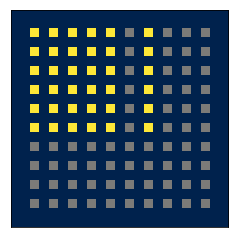

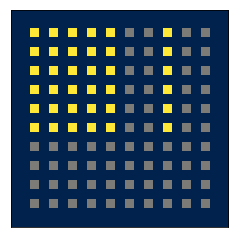

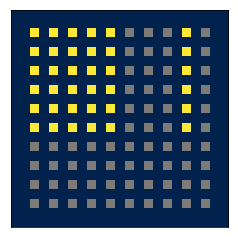

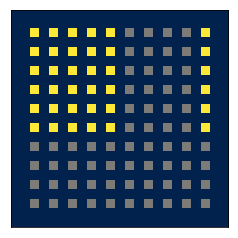

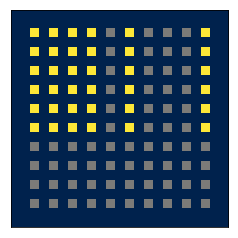

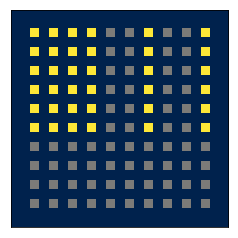

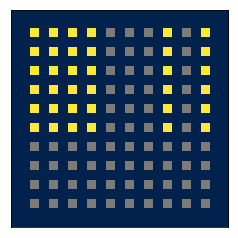

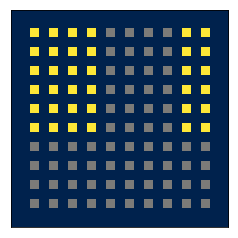

In [209]:
basepic = np.zeros((23,23))
for loc in ah.unpackAtomLocations([2,2,2,10,10]):
    basepic[loc[0]][loc[1]] += 1    
plt.figure()
plt.imshow(basepic, vmin=0, vmax=2, cmap='cividis')
plt.xticks([])
plt.yticks([])
plt.savefig('Stiff_Configs_base.png',transparent=True, bbox_inches='tight', pad_inches=0.1, dpi=400)

locSets = [[6,6,2,6,6], [2,2,2,6,6], [4,2,2,6,6]]
locSets =  [ah.unpackAtomLocations(locs) for locs in locSets]
locSets += [ah.unpackAtomLocations([2,2,2,5,6]) + ah.unpackAtomLocations([2,14,2,1,6])]
locSets += [ah.unpackAtomLocations([2,2,2,5,6]) + ah.unpackAtomLocations([2,16,2,1,6])]
locSets += [ah.unpackAtomLocations([2,2,2,5,6]) + ah.unpackAtomLocations([2,18,2,1,6])]
locSets += [ah.unpackAtomLocations([2,2,2,5,6]) + ah.unpackAtomLocations([2,20,2,1,6])]
locSets += [ah.unpackAtomLocations([2,2,2,4,6]) + ah.unpackAtomLocations([2,12,2,1,6]) + ah.unpackAtomLocations([2,20,2,1,6])]
locSets += [ah.unpackAtomLocations([2,2,2,4,6]) + ah.unpackAtomLocations([2,14,2,1,6]) + ah.unpackAtomLocations([2,20,2,1,6])]
locSets += [ah.unpackAtomLocations([2,2,2,4,6]) + ah.unpackAtomLocations([2,16,2,1,6]) + ah.unpackAtomLocations([2,20,2,1,6])]
locSets += [ah.unpackAtomLocations([2,2,2,4,6]) + ah.unpackAtomLocations([2,18,2,1,6]) + ah.unpackAtomLocations([2,20,2,1,6])]
for i, locs in enumerate(locSets):
    newpic = copy(basepic)
    for loc in locs:
        newpic[loc[0]][loc[1]] += 1
    plt.figure()
    plt.xticks([])
    plt.yticks([])
    plt.imshow(newpic, vmin=0, vmax=2, cmap='cividis')
    plt.savefig('Stiff_Configs_' + str(i) + '.png',transparent=True, bbox_inches='tight', pad_inches=0.1, dpi=400)

In [210]:
print(count25, count25/(len(pics)/2)*100, nomatch/(len(pics)/2))

7 466.6666666666667 2690.6666666666665


In [211]:
0.90**36 * 0.19 * 100

0.42803959135384473

In [212]:
np.mean(survivalList) / 36

0.72642923005993554

# 1D data cross-section

### single atom options

#### thresholds optimized

In [11]:
repsPerVar = 150
borders = [0,4,7,11,60,290,310,350,400,450,500]
errs, pixels, thresh, data = [[None for _ in range(len(borders)-1)] for _ in range(4)]
for bi in range(len(borders)-1):
    begin, end = borders[bi:bi+2]
    res = ma.standardPopulationAnalysis(grey_mol_file, [[2,2]], 0, 1, dataRange=np.arange(begin,end),
                                        picSlice=[begin*repsPerVar,repsPerVar*end], quiet=True);
    errs[bi], thresh[bi], pixels[bi], data[bi] = res[4][0], res[1][0], res[0][0], res[5][0]
with exp.ExpFile(grey_mol_file) as f:
    kn, key_grey = f.get_key()
# # (to see where I set threshold regions)
# x_i = 0
# for p, t in zip(pixels, thresh):
#     plot(np.arange(x_i, x_i + len(p)), p, '.', markersize=1)
#     hlines(t, xmin=x_i, xmax=x_i + len(p),color='k')
#     x_i += len(p)
avg_combined_grey = []
errsCombined = []
for e, l in zip(errs, data):
    avg_combined_grey += l
    errsCombined += e
key1_1, key2_1 = key_grey[:,0], key_grey[:,1]
key1_1 = np.sort(np.unique(key1_1))
key2_1 = np.sort(np.unique(key2_1))
im_2dscan_1 = np.zeros((len(key1_1),len(key2_1)))
err_2d_1 = [[[] for _ in key1_1] for _ in key2_1] #np.zeros((len(key1_1), len(key2_1)))
for i, keyVal in enumerate(key_grey):
    i1 = np.where(key1_1==keyVal[0])[0][0]
    i2 = np.where(key2_1==keyVal[1])[0][0]
    im_2dscan_1[i2,i1] = avg_combined_grey[i]
    err_2d_1[i2][i1] = jeffreyInterval(avg_combined_grey[i],150)#errsCombined[i]

#single_atom_analysis(None, 'Single Atom $\Lambda$-Enhanced Grey Molasses Loading', realsize=True, data=avg_combined_grey, err=errsCombined, key=key_grey, units='grey')
"""
file = None
title='cross-section'
units = 'grey'
showVals = False
realsize=True
save=False
key=key_grey
data=avg_combined_grey
err=errsCombined

if file is not None:
    res = ma.standardPopulationAnalysis( file, [[2,2]], 0, 1, quiet=True );
    ( _, _, _, key, avgLoadingErr, avgLoading, _, _, _, _, _, _, _, _, _, _, _, _,_,_ ) = res
    avgLoading = avgLoading[0]
    avgLoadingErr = avgLoadingErr[0]
else:
    avgLoading = data
    avgLoadingErr = err
key1, key2 = key[:,0], key[:,1]
key1 = np.sort(np.unique(key1))
key2 = np.sort(np.unique(key2))
im_2dscan = np.zeros((len(key1),len(key2)))
err_2d = np.zeros((len(key1), len(key2)))
for i, keyVal in enumerate(key):
    i1 = np.where(key1==keyVal[0])[0][0]
    i2 = np.where(key2==keyVal[1])[0][0]
    im_2dscan[i2,i1] = avgLoading[i]
    err_2d[i2,i1] = avgLoadingErr[i]
f, ax = plt.subplots(4,6,figsize=(40,20))
scaledKey = [misc.round_sig(D1_DacToFreq.f(k)) for k in key1]
for i, (d, e, a) in enumerate(zip(im_2dscan, err_2d, ax.flatten())):
    a.errorbar(scaledKey, d * 100, yerr=e*100,ls='', marker='o', capsize=3, 
               label=misc.round_sig_str(TweezerPowerToDepth.f(key2[i])) + 'mK')
    plt.sca(a)
    plt.grid(True)
    plt.xticks(scaledKey[::3], rotation=25);
    plt.yticks(np.arange(0,110,10));
    plt.xlabel('Cooling-Beam Frequency')
    plt.ylabel('Loading %')
    plt.legend()
plt.savefig('Single_Atom_Slices.png', transparent=True, bbox_inches='tight', pad_inches=0.1)
"""
"""
divider = axesTool.make_axes_locatable(plt.gca())
cax = divider.append_axes('right', size='5%', pad=0.0)    
cb = f.colorbar(im, cax, orientation='vertical');
cb.ax.set_ylabel('Loading %', fontsize=paper_Font_Size)
""";

97.092.0111.0128.0121.0107.086.066.085.097.024.049.0126.0111.0135.02.093.097.099.0107.00.0124.090.071.0113.01.0121.00.00.081.0104.072.093.0105.00.01.078.00.093.0123.00.00.049.068.074.066.071.087.087.00.080.049.00.091.080.00.0114.0133.075.00.0131.00.01.00.0132.088.00.01.00.063.057.00.050.0114.092.0116.00.054.0129.098.099.065.0105.0122.00.09.082.0113.0113.01.0125.039.01.0112.01.031.00.0120.0126.0116.00.03.058.04.0130.00.00.085.0101.0116.084.035.050.00.0124.084.042.076.0120.0122.096.06.023.0103.089.00.0130.0133.0128.0136.076.0103.00.084.039.0102.063.00.089.081.045.088.0108.085.085.0107.01.084.0116.0122.0121.049.0133.0100.0106.090.043.0105.0129.00.077.027.00.040.085.073.058.00.00.093.0103.087.00.089.069.092.082.096.0127.0110.043.00.066.088.030.00.072.00.0133.079.0119.097.0105.0135.0101.0130.096.0118.00.00.085.0127.090.090.095.0119.076.070.078.069.093.0126.00.00.024.00.065.0123.0101.073.0135.0112.0127.0130.051.012.077.03.00.0119.0122.085.0120.0114.088.0111.0125.097.077.0111.0108.028.0111.01

### 10x10 options

thresholds optimized

In [12]:
file = grey_mol_file_10x10
title = '10x10 Atoms Averaged $\Lambda$-Enhanced Loading'
controlUnits = False
showVals = False
realsize=False
save=True
key=None
data=None
err=None
repsPerVar = 100
borders = [int(x) for x in np.linspace(0,484,20)]
errs, pixels, thresh, data = [[[None for _ in range(len(borders)-1)] for _ in range(100)] for _ in range(4)]
for bi in range(len(borders)-1):
    print('.',end='')
    begin, end = borders[bi:bi+2]
    res = ma.standardPopulationAnalysis(file, [3,2,2,10,10], 0, 1, dataRange=np.arange(begin,end),
                                        picSlice=[begin*repsPerVar,repsPerVar*end], quiet=True);
    for ai in range(100):
        errs[ai][bi], thresh[ai][bi], pixels[ai][bi], data[ai][bi] = res[4][ai], res[1][ai], res[0][ai], res[5][ai]
with exp.ExpFile(file) as f:
    kn, key = f.get_key()
key1, key2 = key[:,0], key[:,1]
key1 = np.sort(np.unique(key1))
key2 = np.sort(np.unique(key2))
# we couldn't actually supply powers above ~205mw at this point,
# so the points beyond this are probably misleading.
key2 = [k for k in key2 if k <= 205]
optData = [[] for _ in range(100)]
optErrs = [[] for _ in range(100)]
for atomInc in range(100):
    for borderInc in range(len(data[atomInc])):
        optData[atomInc] += data[atomInc][borderInc]
        optErrs[atomInc] += errs[atomInc][borderInc]
avgAvgLoading = [np.mean(atmLoads) for atmLoads in misc.transpose(optData)]

....

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:785: OptimizeWarning:

Covariance of the parameters could not be estimated



...............

In [13]:
print(arr(optData).shape)
# 44 45 54 55
mid2dScans = [np.zeros((len(key2),len(key1))) for _ in range(4)]
err2dScans = [[[[] for _ in key1] for _ in key2] for _ in range(4)]
for j, which in enumerate([44,45,54,55]):
    for i, keyVal in enumerate(key):
        try:
            i1 = np.where(key1==keyVal[0])[0][0]
            i2 = np.where(key2==keyVal[1])[0][0]
        except IndexError:
            # happens when the loop finds a key with a power that is being discarded.
            continue
        mid2dScans[j][i2,i1] = optData[which][i]
        err2dScans[j][i2][i1] = jeffreyInterval(optData[which][i], 100)#optErrs[which][i]
        # 100 atoms, 100 reps per variation, gives the total rep count here. This is the error averaging over the different atoms.
        #err_2d[i2, i1] = 

(100, 484)
76.00.042.00.078.038.056.074.013.01.077.079.021.020.070.031.09.045.080.00.056.066.05.00.063.00.032.070.079.065.026.00.018.028.08.080.067.057.00.041.035.064.02.05.085.070.040.02.071.044.082.082.067.063.032.070.080.025.013.00.076.046.022.067.075.032.023.07.020.010.07.00.020.082.079.06.047.058.039.065.029.072.033.077.06.09.04.076.023.080.077.082.084.075.081.00.070.076.05.01.017.078.01.039.067.015.047.075.021.076.074.041.01.042.07.055.05.067.059.028.065.02.069.081.033.046.076.023.03.025.075.072.057.039.029.00.00.064.046.031.076.028.06.012.01.068.00.060.00.074.011.076.043.079.09.040.069.015.06.08.03.033.013.045.078.00.028.052.089.011.00.032.010.00.077.075.014.00.072.024.00.00.068.079.071.081.01.025.069.045.04.08.020.03.061.021.057.00.071.018.052.060.061.018.036.042.01.082.070.077.052.05.061.074.082.082.071.00.00.073.081.013.066.021.015.010.075.075.01.00.017.083.011.074.079.025.060.021.067.069.053.01.041.054.011.043.067.077.082.051.085.080.050.02.047.078.03.057.077.083.073.078.00.

7194.037.03799.0134.06605.03307.05220.07765.02336.0231.07377.07124.01682.03720.06167.02773.0780.05482.07781.091.05488.06647.0336.074.06315.055.02495.06840.07860.06274.03188.0159.01392.01827.01126.07421.05575.05042.04.04083.02487.05760.0125.01167.07777.07116.04722.0178.06650.03940.07784.07726.05958.04678.04791.06232.07858.01733.01070.021.07158.03826.02849.06211.06612.03085.02007.0616.02447.0974.01611.035.01475.07809.07840.0783.04014.05921.03673.06661.02320.07206.03082.07321.01130.01141.0234.07862.02640.07082.06794.07456.07804.06757.07446.047.06817.06899.0490.0335.01461.07406.028.03099.06658.0964.04110.07348.02014.06678.06687.04474.031.04599.01147.05255.0253.05911.05815.02302.05183.0122.06659.07630.03866.03775.07230.02141.0287.03042.07614.07259.04957.02742.04565.095.036.06242.03428.02727.07280.02308.01294.01355.0111.06493.014.04656.017.06745.0683.07063.04696.07947.0441.03000.05970.02176.0325.01353.0185.03136.0714.03843.07634.028.02484.04548.07468.0472.021.02736.0923.069.07098.06545.0805.

<Figure size 306x306 with 0 Axes>

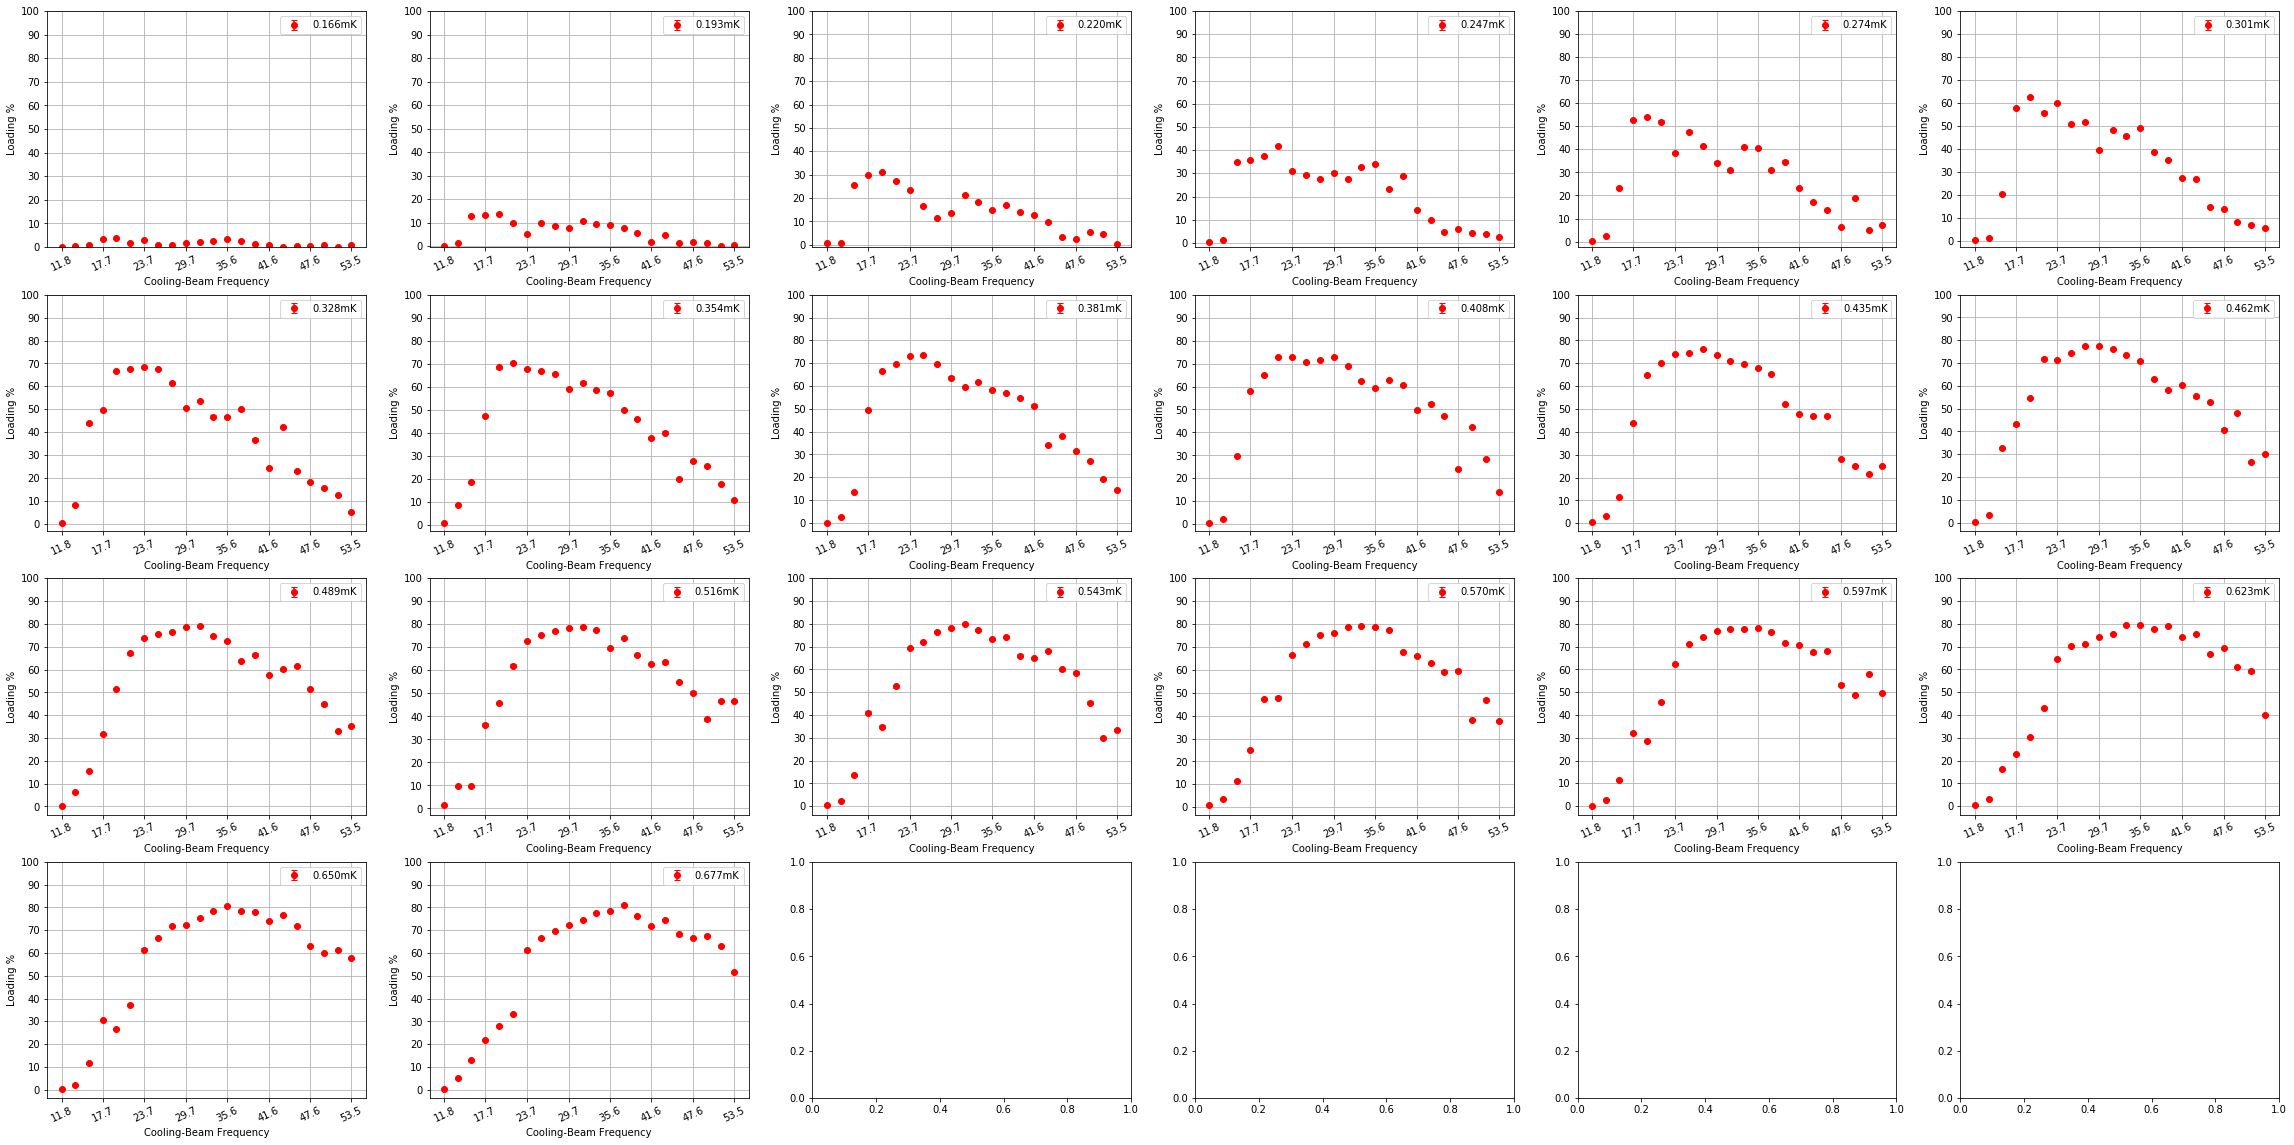

In [14]:
f = plt.figure(figsize=(10,10))
f.set_size_inches(4.25,4.25)
im_2dscan = np.zeros((len(key2),len(key1)))
err_2d = [[[] for _ in key1] for _ in key2]#np.zeros((len(key2),len(key1)))
for i, keyVal in enumerate(key):
    try:
        i1 = np.where(key1==keyVal[0])[0][0]
        i2 = np.where(key2==keyVal[1])[0][0]
    except IndexError:
        # happens when the loop finds a key with a power that is being discarded.
        continue
    av = avgAvgLoading[i]
    im_2dscan[i2,i1] = av
    # 100 atoms, 100 reps per variation, gives the total rep count here. This is the error averaging over the different atoms.
    err_2d[i2][i1] = jeffreyInterval(av, 100*100) #np.sqrt(av*(1-av))/np.sqrt(100*100)

f, ax = plt.subplots(4,6,figsize=(40,20))
scaledKey = [misc.round_sig(D1_DacToFreq.f(k)) for k in key1]
for i, (d, a) in enumerate(zip(im_2dscan, ax.flatten())):
    a.errorbar(scaledKey, d * 100, yerr=arr(misc.transpose(err_2d[i]))*100,ls='', marker='o', capsize=3, 
               label=misc.round_sig_str(TweezerPowerToDepth.f(key2[i])/100.0) + 'mK', color='r')
    plt.sca(a)
    plt.grid(True)
    plt.xticks(scaledKey[::3], rotation=25);
    plt.yticks(np.arange(0,110,10));
    plt.xlabel('Cooling-Beam Frequency')
    plt.ylabel('Loading %')
    plt.legend()
plt.savefig('10x10_Slices.png', transparent=True, bbox_inches='tight', pad_inches=0.1)

### Overlaping plot

In [15]:
import matplotlib as mpl
mpl.rc('font', family='cmr10') 
mpl.rcParams['mathtext.fontset'] = 'cm'
#mpl.rc('font', serif='Helvetica Neue') 
mpl.rc('font', size=9) 

In [16]:
print(misc.round_sig_str(TweezerPowerToDepth.f(key2[which10])/100.0,2))

0.54


0.55
0.54


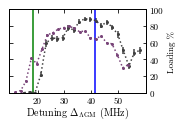

In [17]:
which10 = 14
which1=7
scaledKey_1 = [misc.round_sig(D1_DacToFreq.f(k)) for k in key1_1]
f, a = plt.subplots(1,1)

print(misc.round_sig_str(TweezerPowerToDepth.f(key2_1[which1]),2))
print(misc.round_sig_str(TweezerPowerToDepth.f(key2[which10])/100.0,2))
a.errorbar( scaledKey_1, im_2dscan_1[which1]*100, yerr=arr(misc.transpose(err_2d_1[which1]))*100,ls=':', marker='o', 
              label='Single Trap',color='#404040', markersize=2 )
a.errorbar( scaledKey, im_2dscan[which10] * 100, yerr=arr(misc.transpose(err_2d[which10]))*100,ls=':', marker='o',  
              label='10x10 Average', color='#794579', markersize=2 )
"""
a.errorbar( scaledKey, mid2dScans[0][which10] * 100, yerr=arr(misc.transpose(err2dScans[0][which10])) * 100, ls=':', marker='o', capsize=7, 
              label='mid1 of 10x10', color='#00FF00' )
a.errorbar( scaledKey, mid2dScans[1][which10] * 100, yerr=arr(misc.transpose(err2dScans[1][which10])) * 100, ls=':', marker='o', capsize=7, 
              label='mid2 of 10x10', color='#00DC00' )
a.errorbar( scaledKey, mid2dScans[2][which10] * 100, yerr=arr(misc.transpose(err2dScans[2][which10])) * 100, ls=':', marker='o', capsize=7, 
              label='mid3 of 10x10', color='#00A000' )
a.errorbar( scaledKey, mid2dScans[3][which10] * 100, yerr=arr(misc.transpose(err2dScans[3][which10])) * 100, ls=':', marker='o', capsize=7, 
              label='mid4 of 10x10', color='#007070' )
"""
a.set_xlabel(r'Detuning $\Delta_{\mathrm{\Lambda GM}}$ (MHz)',fontsize=10, labelpad=0)
a.axvline(0.554 * (3*20.8 + 12.0), linestyle='-',color='b')
a.axvline(0.554 * (20.8 + 12.0), linestyle='-',color='g')
a.set_xticks([20,30,40,50])

ax2 = a.twinx()
ay2 = a.twiny()
ay2.set_xticks([20,30,40,50])
ax2.yaxis.tick_left()
ay2.set_xlim(a.get_xlim())
ay2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.set_ylim(0, 100)
a.set_ylim(0, 100)
a.set_ylabel('Loading %')
a.set_yticks([0,20,40,60,80,100])
ax2.set_yticks([0,20,40,60,80,100])
which = 10
wr = 14
a.yaxis.tick_right()
a.yaxis.set_label_position("right")
for ax_ in [a, ax2, ay2]:
    ax_.get_yaxis().set_tick_params(direction='in')
    ax_.get_xaxis().set_tick_params(direction='in')
#f.subplots_adjust(bottom=0.15,top=0.5)
f.set_size_inches(2.45,1.53)
plt.savefig( 'figure_2f.svg', transparent=True, dpi=400 )

# Single Atom

## Red Optimized Loading

In [857]:
with exp.ExpFile(red_optimum_file) as  f:
    f.print_parameters()

 andorimagetime :20.0 
 d1__servo_value :0.293587033492 
 default795freq :0.0 
 defaultmotfreq :0.01 
 diagmot__servo_value :0.273443867549 
 field :3.0 
 fieldphi :0.0 
 fieldtheta :0.0 
 imagingdepth :2.9 
 imagingpower :0.3 
 imagingrepumppower :0.2 
 intrappgccoolingtime :2.0 
 loading_detuning :-0.213 
 loadingdepth :3.3 
 loadmottime :150.0 
 pushouttime :20.0 
 sidemot__servo_value :0.181103350721 


In [211]:
jeffreyInterval(0.640,2000)

1280

(0.010800809974236381, 0.010660847566420495)

In [67]:
TweezerPowerToDepth.f(3.3)

1.0965410797446704

In [73]:
MOT_DacToFreq.f(-0.213)/1e6

-13.642579060187817

Number of Pictures: 2000
Picture Dimensions: 5 x 5
Variaitons: 1
Repetitions: 2000
Experiment started at (H:M:S)  13:10:26:  on (Y-M-D) 2018-8-17
Analyzing Variation... 0, [0.0]


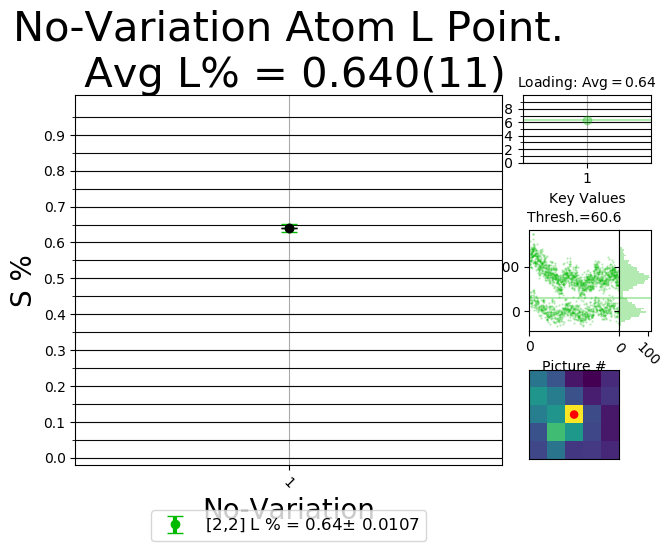

In [90]:
res = mp.Loading(red_optimum_file, [[2,2]], avgColor='k', mainAlpha=1,showImagePlots=False);

In [91]:
res['Thresholds'][0].fidelity

0.98690818007828196

## Optimized Loading

### raw data

In [ ]:
with exp.ExpFile(single_optimum_file) as f:
    f.print_all()

In [10]:
with exp.ExpFile(single_optimum_file) as f:
    f.print_parameters()

 andorimagetime :20.0 
 cooling_time :200.0 
 d1__servo_value :0.293587033492 
 d1twototwoppower :0.3 
 default795freq :0.0 
 defaultmotfreq :0.01 
 diagmot__servo_value :0.273443867549 
 field :3.0 
 fieldphi :0.0 
 fieldtheta :0.0 
 grey_detuning :0.7 
 imagingdepth :3.0 
 imagingpower :0.3 
 imagingrepumppower :0.2 
 intrappgccoolingtime :2.0 
 loadingdepth :1.9 
 loadmottime :150.0 
 pushouttime :20.0 
 rsfreq :0.14 
 rspow :5.0 
 sidemot__servo_value :0.181103350721 


#### optimized atom loading grey paper (annotated afterwards)

Number of Pictures: 1000; Picture Dimensions: 5 x 5
Variations: 1;	Repetitions: 1000
Experiment started at (H:M:S)  on (Y-M-D) , And ended at  on 
Experiment Rationale: _
Experiment Result: _



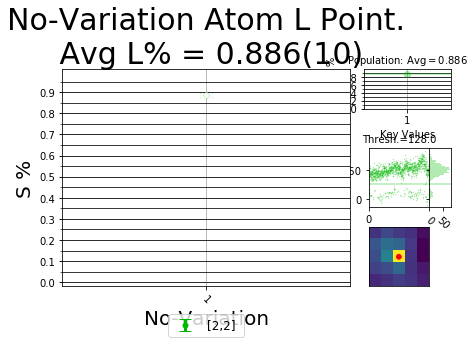

In [12]:
res = mp.Loading(single_optimum_file, [[2,2]], avgColor='k', mainAlpha=1,showImagePlots=False);

In [13]:
res['Thresholds'][0].fidelity

0.99771039419080187

In [14]:
TweezerPowerToDepth.f(1.9)

0.631341833792386

In [15]:
D1_DacToFreq.f(0.7)

44.74464841200003

In [16]:
jeffreyInterval(0.886,1000)

886

(0.010436025378991687, 0.0096643990652945932)

In [17]:
with exp.ExpFile(single_optimum_file) as f:
    avgPic = f.get_avg_pic()

In [21]:
import matplotlib.patches as patches


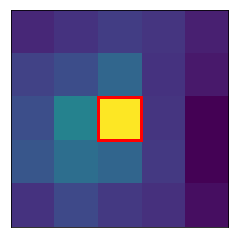

In [37]:
plt.imshow(avgPic)
plt.xticks([])
plt.yticks([]);
plt.gca().add_patch(patches.Rectangle((1.5,1.5),1,1, edgecolor='#FF0000', linewidth=3, facecolor='#00000000'))
#plt.savefig('Single_Atom_Image.png', transparent=True, bbox_inches='tight', pad_inches=0.1, dpi=400)

### Optimized Loading Video

In [39]:
def makeVid( pics, gifAddress, videoType, fileAddress=None, dur=1, lim=None, includeCount=True, lowLim=None, 
             finLabels=[], finTxt="Atom Reservoir Depleted", vidMap=infernoMap ):
    # global count
    # select subsection
    if lim is None:
        lim = len(pics)
    if lowLim is None:
        lowLim = 0
    pics = pics[lowLim:lim]
    # normalize to rgb scale
    pics = pics - min(pics.flatten())
    pics = np.uint16(pics / max(pics.flatten()) * 500)
    pics = arr([[[int(elem) for elem in row] for row in pic] for pic in pics])
    pics = arr(pics-min(pics.flatten()) - 200)
    pics = [[[vidMap[elem] if elem < 256 and elem >= 0 else vidMap[255] if elem >= 256 else vidMap[0] 
              for elem in row] for row in pic] for pic in pics]
    images = []
    sequenceCount = 1
    offset = 0
    for picCount, pic in enumerate(pics):
        fig = plt.figure()
        fig.set_size_inches([9,9])
        ax = plt.Axes(fig, [0., 0., 1., 1.])
        ax.set_axis_off()
        fig.add_axes(ax)
        plt.grid(False)
        ax.imshow(pic, aspect='equal')
        ax.add_patch(patches.Rectangle((1.5,1.5),1,1, edgecolor='#FF0000', linewidth=2, facecolor='#00000000'))
        #ax.text(1, 1, str(picCount+1-offset), color='white', fontsize=40)
        if picCount+1 in finLabels:
            ax.text(1.5, 14, finTxt, color='r', fontsize=40)
        name = "temp"+str(picCount+1)+".png"
        plt.savefig(name)
        images.append(imageio.imread(name))
        if picCount+1 in finLabels:
            sequenceCount += 1
            offset = picCount+1
            for _ in range(4):
                images.append(imageio.imread(name))
        plt.close('all')
    # make bigger
    pics = [np.repeat(np.repeat(pic,32, axis=0), 32, axis=1) for pic in pics]
    imageio.mimsave(gifAddress, images, format=videoType, duration=dur)

In [40]:
makeVid(res['Raw_Data'][50:150], 'Optimized_Single_Atom__ppt.gif', 'gif', dur=0.3,vidMap=viridisMap);

## OOO Grey Molasses Detuning & Trap Depth Vs Loading

### OOO Option 1

#### Raw Analysis

In [ ]:
with exp.ExpFile(grey_mol_file) as f:
    f.print_all()

72600 72600 484 hi
-7.55 
 [15.1, 17.100000000000001, 19.100000000000001, 21.199999999999999, 23.199999999999999, 25.300000000000001, 27.300000000000001, 29.399999999999999, 31.399999999999999, 33.399999999999999, 35.5, 37.5, 39.600000000000001, 41.600000000000001, 43.600000000000001, 45.700000000000003, 47.700000000000003, 49.799999999999997, 51.799999999999997, 53.899999999999999, 55.899999999999999, 57.899999999999999]


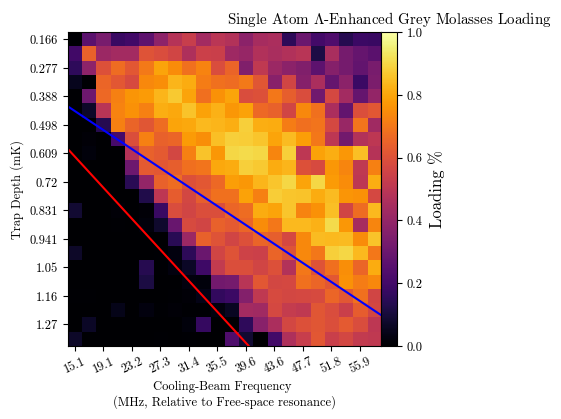

In [54]:
single_atom_analysis(grey_mol_file, 'Single Atom $\Lambda$-Enhanced Grey Molasses Loading', realsize=True, units='grey');

#### raw 3d bar plot (bad...)

something's wrong with the plot...

In [840]:
from mpl_toolkits.mplot3d import Axes3D

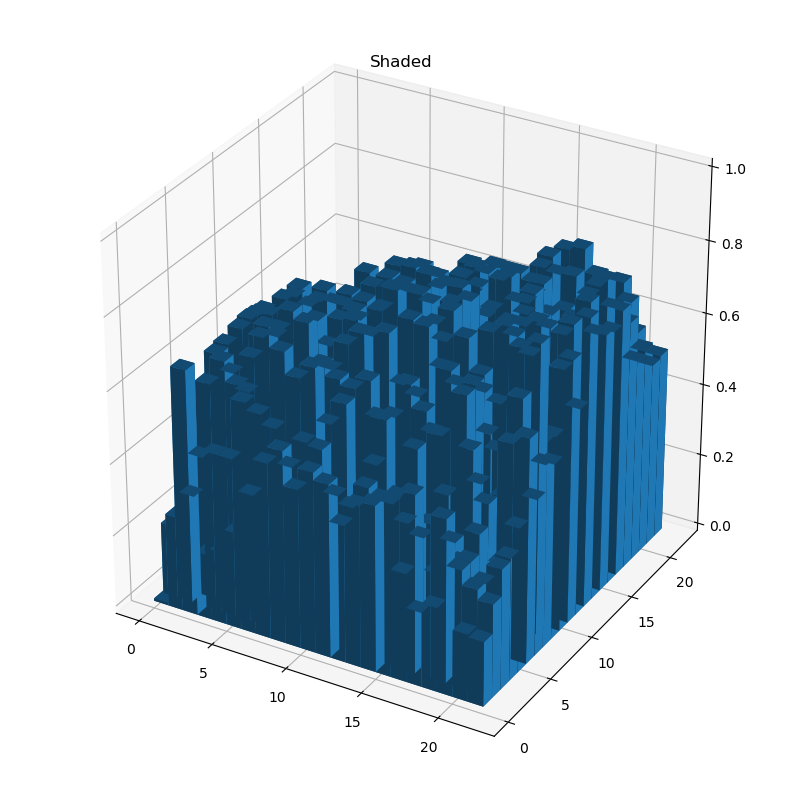

In [44]:
file = grey_mol_file
title = 'Single Atom $\Lambda$-Enhanced Grey Molasses Loading'
realsize=False
if file is not None:
    res = ma.standardPopulationAnalysis( file, [[2,2]], 0, 1, quiet=True );
    ( _, _, _, key, avgLoadingErr, avgLoading, _, _, _, _, _, _, _, _, _, _, _, _,_,_ ) = res
    avgLoading = avgLoading[0]
    avgLoadingErr = avgLoadingErr[0]
else:
    avgLoading = data
    avgLoadingErr = err
key1, key2 = key[:,0], key[:,1]
key1 = np.sort(np.unique(key1))
key2 = np.sort(np.unique(key2))
im_2dscan = np.zeros((len(key1),len(key2)))
f = plt.figure(figsize=(10,10))
if realsize:
    f.set_size_inches(4.25, 4.25)
for i, keyVal in enumerate(key):
    i1 = np.where(key1==keyVal[0])[0][0]
    i2 = np.where(key2==keyVal[1])[0][0]
    im_2dscan[i2,i1] = avgLoading[i]
    if showVals:
        plt.text(i1-0.5, i2+0.25, misc.round_sig(avgLoading[i],2), fontsize=6, color='g')
        plt.text(i1-0.5, i2-0.25, misc.round_sig(avgLoadingErr[i],2), fontsize=6, color='g')

ax1 = f.add_subplot(111, projection='3d')
# fake data
_xx, _yy = np.meshgrid(range(len(key2)), range(len(key1)))
x, y = _xx.ravel(), _yy.ravel()
bottom = np.zeros_like(x)
width = depth = 1

ax1.bar3d(x, y, bottom, width, depth, im_2dscan.ravel(), shade=True )
ax1.set_title('Shaded')
ax1.set_zlim(0,1);
#im = plt.imshow(im_2dscan, cmap='inferno', vmin=0, vmax=1)
#plt.grid(False)
#plt.xlabel('Cooling-Beam Frequency \n(MHz, Relative to Free-space resonance)')
#plt.ylabel('Trap Depth (mK)')
#if controlUnits:
#    plt.xticks(range(0,len(key1),2),[misc.round_sig(k) for k in key1[::2]], rotation=50)
#    plt.yticks(range(0,len(key2),2),[misc.round_sig(k) for k in key2[::2]])
#else:
#    plt.xticks(range(0,len(key1),2),[misc.round_sig(D1_DacToFreq.f(k)) for k in key1[::2]],rotation=25);
#    plt.yticks(range(0,len(key2),2),[misc.round_sig(TweezerPowerToDepth.f(k)) for k in key2[::2]]);
#divider = axesTool.make_axes_locatable(plt.gca())
#cax = divider.append_axes('right', size='5%', pad=0.0)    
#cb = f.colorbar(im, cax, orientation='vertical');
#cb.ax.set_ylabel('Loading %', fontsize=paper_Font_Size)
#if save:
#    plt.savefig(title + '.png', transparent=True, bbox_inches='tight', pad_inches=0.1)
#plt.title(title)

#### OOO Optimizing Thresholds

In [57]:
fids = [atom.fidelity for atom in tbin for tbin in thresh]
np.mean(fids)

NameError: name 'tbin' is not defined

In [23]:
print(len(borders))

20


In [24]:
arr(thresh).shape

(100, 19)

In [25]:
avgFid = 0
for i, tbin in enumerate(thresh):
    weight = borders[i+1] - borders[i]
    avgFid += atom.fidelity * weight
avgFid /= 484*1
print(avgFid)

NameError: name 'atom' is not defined

In [56]:
res = ma.standardPopulationAnalysis(grey_mol_file, [[2,2]], 0, 1, quiet=False);

Number of Pictures: 72600; Picture Dimensions: 5 x 5
Variations: 484;	Repetitions: 150
Experiment started at (H:M:S)  on (Y-M-D) , And ended at  on 
Experiment Rationale: HDF5 NOT ANNOTATED: please call exp.Annotate() to annotate this file.
Experiment Result: HDF5 NOT ANNOTATED: please call exp.Annotate() to annotate this file.

72600 72600 484 hi
Analyzing Variation... 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 14

In [58]:
arr(res[5][0]).shape

(484,)

600 600 4 hi
450 450 3 hi
600 600 4 hi
7350 7350 49 hi
34500 34500 230 hi
3000 3000 20 hi
6000 6000 40 hi
7500 7500 50 hi
7500 7500 50 hi
5100 5100 34 hi


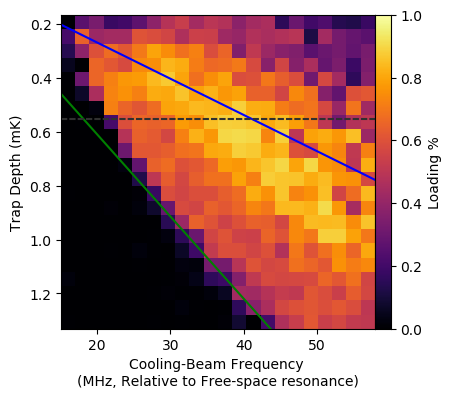

In [100]:
repsPerVar = 150
borders = [0,4,7,11,60,290,310,350,400,450,484]
errs, pixels, thresh, data = [[None for _ in range(len(borders)-1)] for _ in range(4)]
thresholdData = []
for bi in range(len(borders)-1):
    begin, end = borders[bi:bi+2]
    res = ma.standardPopulationAnalysis(grey_mol_file, [[2,2]], 0, 1, dataRange=np.arange(begin,end),
                                        picSlice=[begin*repsPerVar,repsPerVar*end], quiet=True);
    errs[bi], thresh[bi], pixels[bi], data[bi] = res[4][0], res[1][0], res[0][0], res[5][0]
with exp.ExpFile(grey_mol_file) as f:
    kn, key_grey = f.get_key()
# # (to see where I set threshold regions)
#x_i = 0
#for p, t in zip(pixels, thresh):
#    plot(np.arange(x_i, x_i + len(p)), p, '.', markersize=1)
#    hlines(t, xmin=x_i, xmax=x_i + len(p),color='k')
#    x_i += len(p)
avg_combined_grey = []
errsCombined = []
for e, l in zip(errs, data):
    avg_combined_grey += l
    errsCombined += e
single_atom_analysis_(None, 'Single_Atom_Grey_2D_Scan_k', realsize=True, data=avg_combined_grey, err=errsCombined, 
                      key=key_grey, units='grey', save=True, showVals=False, textColor='k', fileExt='.svg')

### Option 2

58080 58080 484 hi


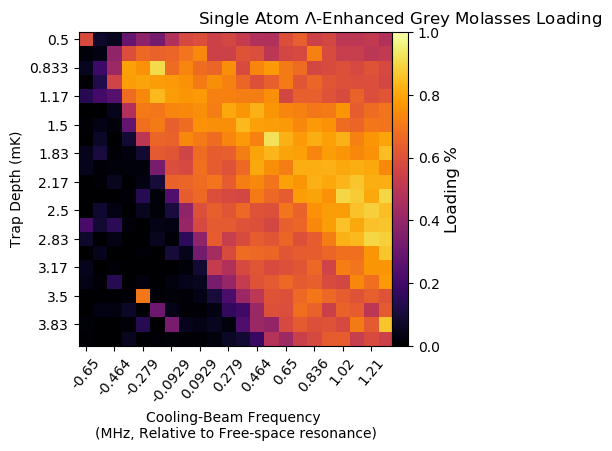

In [15]:
single_atom_analysis(alt_grey_mol_file, 'Single Atom $\Lambda$-Enhanced Grey Molasses Loading', realsize=True)

#### Optimizing Thresholds

1320 1320 11 hi
1440 1440 12 hi
1080 1080 9 hi
1200 1200 10 hi
1200 1200 10 hi
1200 1200 10 hi
2160 2160 18 hi
3600 3600 30 hi
1200 1200 10 hi


C:\Users\Mark-Brown\Documents\Analysis-Code\Grey-Loading-Paper\fitters\Gaussian\gaussian.py:29: RuntimeWarning:

divide by zero encountered in true_divide

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:785: OptimizeWarning:

Covariance of the parameters could not be estimated



4800 4800 40 hi
1800 1800 15 hi
1800 1800 15 hi
8400 8400 70 hi
2400 2400 20 hi
3600 3600 30 hi
3600 3600 30 hi
7200 7200 60 hi
6000 6000 50 hi
4080 4080 34 hi


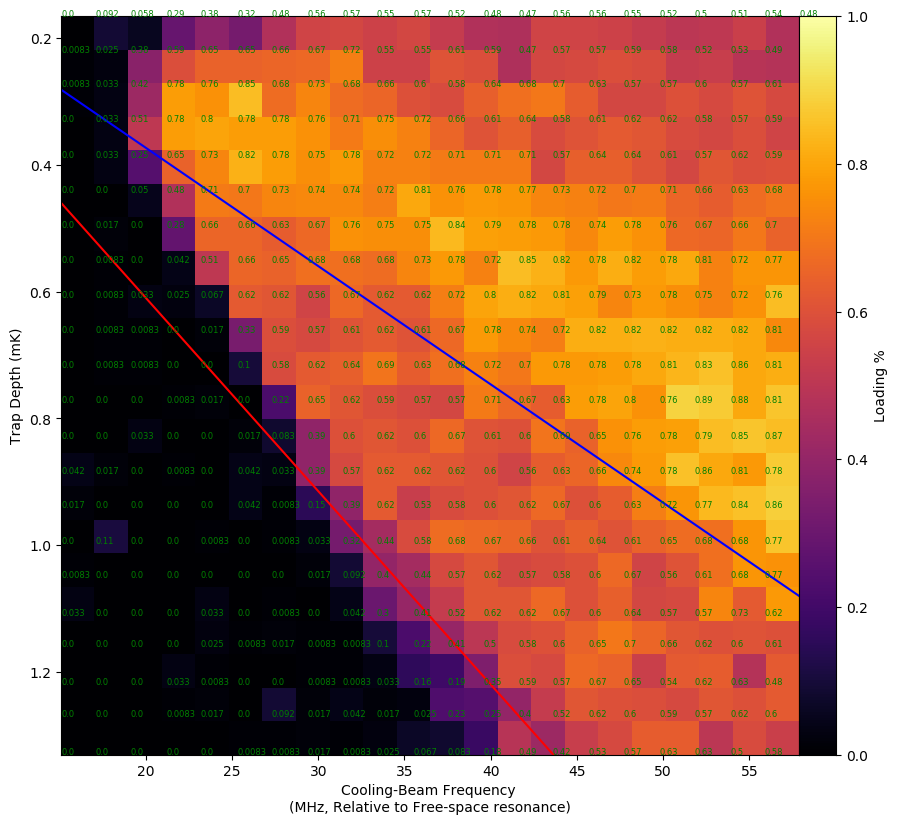

In [16]:
repsPerVar = 120
borders = [0,11,23,32,42,52,62,80,110,120,160,175,190,260,280,310,340,400,450,500]
errs, pixels, thresh, data = [[None for _ in range(len(borders)-1)] for _ in range(4)]
for bi in range(len(borders)-1):
    begin, end = borders[bi:bi+2]
    res = ma.standardPopulationAnalysis(alt_grey_mol_file, [[2,2]], 0, 1, dataRange=np.arange(begin,end),
                                        picSlice=[begin*repsPerVar,repsPerVar*end], quiet=True);
    errs[bi], thresh[bi], pixels[bi], data[bi] = res[4][0], res[1][0], res[0][0], res[5][0]
with exp.ExpFile(alt_grey_mol_file) as f:
    kn, key = f.get_key()
# # (to see where I set threshold regions)
#x_i = 0
#for p, t in zip(pixels, thresh):
#    plot(np.arange(x_i, x_i + len(p)), p, '.', markersize=1)
#    hlines(t, xmin=x_i, xmax=x_i + len(p),color='k')
#    x_i += len(p)
avg_combined = []
errsCombined = []
for e, l in zip(errs, data):
    avg_combined += l
    errsCombined += e
single_atom_analysis_( None, 'Single Atom $\Lambda$-Enhanced Grey Molasses Loading',
                       realsize=False, data=avg_combined, err=errsCombined, key=key, units='grey', showVals=True )

In [17]:
    key1, key2 = key[:,0], key[:,1]
    key1 = np.sort(np.unique(key1))
    key2 = np.sort(np.unique(key2))
    im_2dscan = np.zeros((len(key1),len(key2)))
    xKey = [misc.round_sig(D1_DacToFreq.f(k)) for k in key1]
    yKey = [misc.round_sig(TweezerPowerToDepth.f(k)) for k in key2]

In [18]:
for i, keyVal in enumerate(key):
    i1 = np.where(key1==keyVal[0])[0][0]
    i2 = np.where(key2==keyVal[1])[0][0]
    im_2dscan[i2,i1] = avg_combined[i]

In [19]:
with open('Alt_2D.txt','w') as f:
    for x in xKey:
        f.write(str(x)+',')
    f.write('\n')
    for y in yKey:
        f.write(str(y)+',')
    f.write('\n')
    for e in im_2dscan.flatten():
        f.write(str(e) + ',')

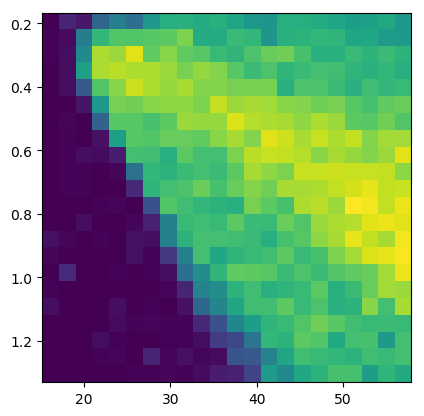

In [20]:
with open('Alt_2D.txt') as f:
    lines = f.readlines()
    xkey = [float(x) for x in lines[0].split(',')[:-1]]
    ykey = [float(y) for y in lines[1].split(',')[:-1]]
    data = [float(z) for z in lines[2].split(',')[:-1]]
data = np.reshape(data, (22,22))
mi_x, ma_x = min(xkey), max(xkey)
mi_y, ma_y = min(ykey), max(ykey)
plt.imshow(data, extent=(mi_x,ma_x,ma_y,mi_y),aspect=(ma_x-mi_x)/(ma_y-mi_y))

## OOO Red PGC Detuning & Trap Depth Vs Loading

### Raw Data

In [ ]:
with exp.ExpFile(red_pgc_file) as f:
    f.print_all_groups()
    #f.print_functions(brief=False)

72600 72600 484 hi


UnboundLocalError: local variable 'xintercept' referenced before assignment

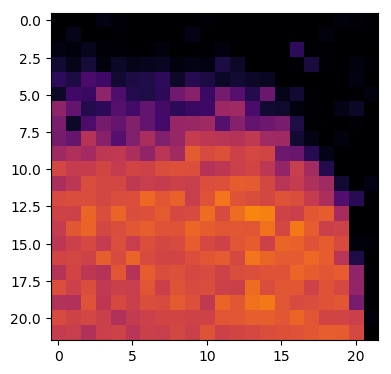

In [22]:
single_atom_analysis(red_pgc_file, 'Standard Red PGC Based Loading', realsize=True, units='red')

### OOO Optimizing Thresholds

3000 3000 20 hi
750 750 5 hi
1500 1500 10 hi
1500 1500 10 hi
750 750 5 hi
2250 2250 15 hi
3750 3750 25 hi
3000 3000 20 hi
13500 13500 90 hi
7500 7500 50 hi
7500 7500 50 hi
7500 7500 50 hi
7500 7500 50 hi
12600 12600 84 hi


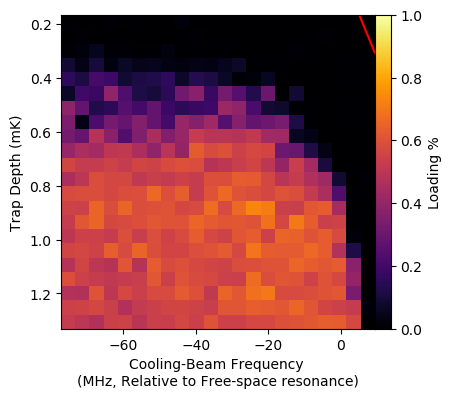

In [102]:
repsPerVar = 150
borders = [0,20,25,35,45, 50, 65, 90, 110, 200,250,300,350,400,650]
errs, pixels, thresh, data = [[None for _ in range(len(borders)-1)] for _ in range(4)]
for bi in range(len(borders)-1):
    begin, end = borders[bi:bi+2]
    res = ma.standardPopulationAnalysis(red_pgc_file, [[2,2]], 0, 1, dataRange=np.arange(begin,end),
                                        picSlice=[begin*repsPerVar,repsPerVar*end], quiet=True);
    errs[bi], thresh[bi], pixels[bi], data[bi] = res[4][0], res[1][0], res[0][0], res[5][0]
with exp.ExpFile(red_pgc_file) as f:
    kn, key_red = f.get_key()
# # (to see where I set threshold regions)
#x_i = 0
#for p, t in zip(pixels, thresh):
#    plot(np.arange(x_i, x_i + len(p)), p, '.', markersize=1)
#    hlines(t, xmin=x_i, xmax=x_i + len(p),color='k')
#    x_i += len(p)
avg_combined_red = []
errsCombined = []
for e, l in zip(errs, data):
    avg_combined_red += l
    errsCombined += e
single_atom_analysis_(None, 'Single_Atom_Red_2D_Scan_k', realsize=True, data=avg_combined_red, err=errsCombined, key=key_red, 
                      units='red', save=True, showVals=False, textColor='k', fileExt='.svg')

# Combined Red & Blue Loading

Need to run the individual runs above first...

In [24]:
key1_r, key2_r = key_red[:,0], key_red[:,1]
key1_r = np.sort(np.unique(key1_r))
key2_r = np.sort(np.unique(key2_r))

key1_g, key2_g = key_grey[:,0], key_grey[:,1]
key1_g = np.sort(np.unique(key1_g))
key2_g = np.sort(np.unique(key2_g))

In [25]:
from matplotlib.colors import LinearSegmentedColormap
customCmap = []
inf = mpl.cm.get_cmap('inferno')
bcm = LinearSegmentedColormap.from_list( 'Custom_', [(0,0,1),(1,1,1)], N=255 )
s1 = 0.74
s2 = 1 - s1
for i in range(round(s1*255)):
    customCmap.append(inf(round(i/s1)))
for i in range(round(s2*255)):
    customCmap.append(bcm(round(i/s2)))
customCm = LinearSegmentedColormap.from_list( 'Custom', customCmap, N=255 )

#### cbar right

In [104]:
mpl.rc('font', family='cmr10') 
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['text.usetex'] = False

#mpl.rc('font', serif='Helvetica Neue') 
mpl.rc('font', size=9)

In [105]:
mpl.rcParams['axes.unicode_minus']= False

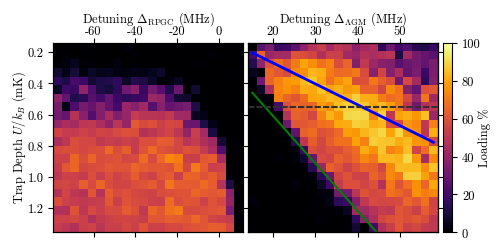

In [107]:
textColor='k'
from matplotlib.font_manager import FontProperties
#cmap = customCm
cmap = 'inferno'
fs = 9
steepColor='g'
redImg = np.zeros((len(key1_r),len(key2_r)))
for i, keyVal in enumerate(key_red):
    i1 = np.where(key1_r==keyVal[0])[0][0]
    i2 = np.where(key2_r==keyVal[1])[0][0]
    redImg[i2,i1] = avg_combined_red[i]

greyImg = np.zeros((len(key1_g),len(key2_g)))
for i, keyVal in enumerate(key_grey):
    i1 = np.where(key1_g==keyVal[0])[0][0]
    i2 = np.where(key2_g==keyVal[1])[0][0]
    greyImg[i2,i1] = avg_combined_grey[i]

xKey_r = [misc.round_sig(MOT_DacToFreq.f(k)*1e-6) for k in key1_r]
yKey_r = [misc.round_sig(TweezerPowerToDepth.f(k)) for k in key2_r]

xKey_g = [misc.round_sig(D1_DacToFreq.f(k)) for k in key1_g]
yKey_g = [misc.round_sig(TweezerPowerToDepth.f(k)) for k in key2_g]

# mK per MHz
slope = 1 /( 20.8 + 9.86)
xpts = np.linspace(xKey_r[0], xKey_r[-1], 1000)

f = plt.figure()
#ax = axesTool.AxesGrid( f, 111, nrows_ncols=(1, 2), axes_pad=0.0, share_all=True,
#                        label_mode="L", cbar_location="right", cbar_mode="single" )

#f, ax = plt.subplots(1,2)
f.set_size_inches([6.6,2.6])
f.subplots_adjust(wspace=0.05, bottom=0.15,left=0.08,right=0.92)

ax = axesTool.ImageGrid( f, 111, nrows_ncols=(1,2), axes_pad=0.05, #share_all=True, label_mode="L",
                         cbar_location="right", cbar_mode="single", cbar_size="5%", cbar_pad=0.05 )
plt.sca(ax[0])
#plt.title('Standard Loading', y=1.1)
#plt.yticks(range(0,len(key2_r),2),[misc.round_sig(TweezerPowerToDepth.f(k)) for k in key2_r[::2]]);
#plt.xticks(range(0,len(key1_r),2),[misc.round_sig(MOT_DacToFreq.f(k)*1e-6) for k in key1_r[::2]], rotation=45);
plt.xlabel('Detuning $\Delta_{\mathrm{RPGC}}$ (MHz)',fontsize=fs,labelpad=15, color=textColor)

plt.sca(ax[1])
#plt.title('$\Lambda$-Enhanced Loading')
#plt.xticks(range(0,len(key1_g),2),[misc.round_sig(D1_DacToFreq.f(k)) for k in key1_g[::2]], rotation=45);
plt.xlabel(r'Detuning $\Delta_{\mathrm{\Lambda GM}}$ (MHz)',fontsize=fs,labelpad=15, color=textColor)

#ax[0].plot(xpts, linear.f(xpts, slope, 0), color=steepColor, zorder=2 )
#ax[0].plot(xpts, linear.f(xpts, slope, slope * 30), color=steepColor, linestyle='-.', zorder=2 )
ax[0].set_ylabel('Trap Depth $U/k_B$ (mK)', fontsize=fs, labelpad=0, color=textColor)
# 
slope = 1/(20.8 + 12.0)
slopeDepthDetuned = 1/(3 * 20.8 + 12.0)
xpts = np.linspace(xKey_g[0], xKey_g[-1], 1000)
ax[1].plot(xpts, linear.f(xpts, slope, 0), color=steepColor, zorder=2 )
# ax[1].plot(xpts, linear.f(xpts, slope, -slope*15), color=steepColor, linestyle='-.', zorder=2 )
ax[1].plot(xpts, linear.f(xpts, slopeDepthDetuned, 0), color='b', linestyle='-',zorder=2, linewidth=2 )
ax[1].axhline(yKey_g[7],color='#303030',dashes=[3,1])
#ax[1].axhline((yKey_g[6] + yKey_g[7]+0.02)/2,color='k')
#ax[1].axhline((yKey_g[7] + yKey_g[8]+0.01)/2,color='k')
#ax[1].set_yticklabels([])
xw = xKey_r[1] - xKey_r[0]
yw = yKey_r[1] - yKey_r[0]
ax[0].imshow( redImg*100, cmap=cmap, vmin=0, vmax=100, zorder=1,
              extent = [xKey_r[0] - xw/2, xKey_r[-1] + xw/2, yKey_r[-1] + yw/2, yKey_r[0] - yw/2], 
              aspect=(xKey_r[-1]-xKey_r[0])/(yKey_r[-1]-yKey_r[0]) )
xw = xKey_g[1] - xKey_g[0]
yw = yKey_g[1] - yKey_g[0]
im = ax[1].imshow( greyImg * 100, cmap=cmap, vmin=0, vmax=100, zorder=1,
                   extent = [xKey_g[0] - xw/2, xKey_g[-1] + xw/2, yKey_g[-1] + yw/2, yKey_g[0] - yw/2], 
                   aspect=(xKey_g[-1]-xKey_g[0])/(yKey_g[-1]-yKey_g[0]))

ax[0].set_xticklabels([])
ax[0].xaxis.set_label_position('top') 
ax0y = ax[0].twiny()
ax0y.set_xlim(ax[0].get_xlim())
ax0y.tick_params(axis='x', which='major', pad=0,colors=textColor)

ax[1].xaxis.tick_top()
ax[1].xaxis.set_label_position('top') 
ax[1].set_xticklabels([])
ax1x = ax[1].twinx()
ax1x.set_ylim(ax[1].get_ylim())
ax1x.set_yticklabels([])
ax1y = ax[1].twiny()
ax1y.set_xlim(ax[1].get_xlim())
ax1y.tick_params(axis='x', which='major', pad=0, colors=textColor)

cb = ax.cbar_axes[0].colorbar(im);
cb.set_label_text("Loading %",color=textColor)
cb.ax.get_yaxis().labelpad = -2
ax[0].xaxis.label.set_color(textColor)
ax[0].tick_params(axis='both', colors=textColor)
ax[1].xaxis.label.set_color(textColor)
ax[1].tick_params(axis='x', colors=textColor)
cb.ax.tick_params(axis='y', colors=textColor)
f.set_facecolor('#00000000')
# font = FontProperties()
# font.set_family( 'cmb10' )
# font.set_size( 8 )
# ax[0].text( -5, 0.3,'a',color='w', fontproperties=font )
# ax[1].text( 20, 1.2,'b',color='w', fontproperties=font )
plt.savefig( 'Fig2bc_k.svg', transparent=True, pad_inches=0, dpi=800)

In [29]:
0.83**36

0.0012212689780225874

In [30]:
0.001**(1/36)

0.8254041852680184

In [ ]:
0.x=0.001

In [32]:
print(yKey_r[0], yKey_r[1], yKey_r[-3],xKey_r[-3],xKey_r[-4])

0.166 0.222 1.22 1.19 -2.93


#### 3 plots

NameError: name 'key1_1' is not defined

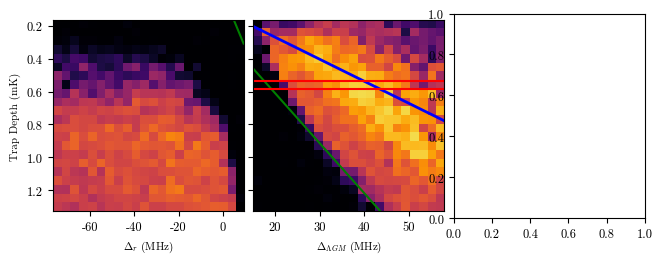

In [33]:
from matplotlib.font_manager import FontProperties
#cmap = customCm
cmap = 'inferno'
fs = 8
steepColor='g'
redImg = np.zeros((len(key1_r),len(key2_r)))
for i, keyVal in enumerate(key_red):
    i1 = np.where(key1_r==keyVal[0])[0][0]
    i2 = np.where(key2_r==keyVal[1])[0][0]
    redImg[i2,i1] = avg_combined_red[i]

greyImg = np.zeros((len(key1_g),len(key2_g)))
for i, keyVal in enumerate(key_grey):
    i1 = np.where(key1_g==keyVal[0])[0][0]
    i2 = np.where(key2_g==keyVal[1])[0][0]
    greyImg[i2,i1] = avg_combined_grey[i]

xKey_r = [misc.round_sig(MOT_DacToFreq.f(k)*1e-6) for k in key1_r]
yKey_r = [misc.round_sig(TweezerPowerToDepth.f(k)) for k in key2_r]

xKey_g = [misc.round_sig(D1_DacToFreq.f(k)) for k in key1_g]
yKey_g = [misc.round_sig(TweezerPowerToDepth.f(k)) for k in key2_g]

# mK per MHz
slope = 1 /( 20.8 + 9.86)
xpts = np.linspace(xKey_r[0], xKey_r[-1], 1000)

f, ax = plt.subplots(1,3)
f.set_size_inches([7.05,2.8])
f.subplots_adjust(wspace=0.05, bottom=0.15,left=0.08,right=0.92)
#ax = axesTool.ImageGrid( f, 111, nrows_ncols=(1,2), axes_pad=0.15, #share_all=True, label_mode="L",
#                         cbar_location="top", cbar_mode="single", cbar_size="150%", cbar_pad=0.15 )
plt.sca(ax[0])
#plt.title('Standard Loading', y=1.1)
#plt.yticks(range(0,len(key2_r),2),[misc.round_sig(TweezerPowerToDepth.f(k)) for k in key2_r[::2]]);
#plt.xticks(range(0,len(key1_r),2),[misc.round_sig(MOT_DacToFreq.f(k)*1e-6) for k in key1_r[::2]], rotation=45);
plt.xlabel('$\Delta_r$ (MHz)',fontsize=fs)

plt.sca(ax[1])
#plt.title('$\Lambda$-Enhanced Loading')
#plt.xticks(range(0,len(key1_g),2),[misc.round_sig(D1_DacToFreq.f(k)) for k in key1_g[::2]], rotation=45);
plt.xlabel(r'$\Delta_{\Lambda GM}$ (MHz)',fontsize=fs)

ax[0].plot(xpts, linear.f(xpts, slope, 0), color=steepColor, zorder=2 )
#ax[0].plot(xpts, linear.f(xpts, slope, slope * 30), color=steepColor, linestyle='-.', zorder=2 )
ax[0].set_ylabel('Trap Depth (mK)', fontsize=fs)
# 
slope = 1/(20.8 + 12.0)
slopeDepthDetuned = 1/(3 * 20.8 + 12.0)
xpts = np.linspace(xKey_g[0], xKey_g[-1], 1000)
ax[1].plot(xpts, linear.f(xpts, slope, 0), color=steepColor, zorder=2 )
# ax[1].plot(xpts, linear.f(xpts, slope, -slope*15), color=steepColor, linestyle='-.', zorder=2 )
ax[1].plot(xpts, linear.f(xpts, slopeDepthDetuned, 0), color='b', linestyle='-',zorder=2, linewidth=2 )
ax[1].axhline((yKey_g[6] + yKey_g[7]+0.02)/2,color='r')
ax[1].axhline((yKey_g[7] + yKey_g[8]+0.01)/2,color='r')
ax[1].set_yticklabels([])
ax[0].imshow( redImg*100, cmap=cmap, vmin=0, vmax=100, zorder=1,
              extent = [xKey_r[0],xKey_r[-1], yKey_r[-1],yKey_r[0]], 
              aspect=(xKey_r[-1]-xKey_r[0])/(yKey_r[-1]-yKey_r[0]) )
im = ax[1].imshow( greyImg * 100, cmap=cmap, vmin=0, vmax=100, zorder=1,
                   extent = [xKey_g[0],xKey_g[-1], yKey_g[-1],yKey_g[0]], 
                   aspect=(xKey_g[-1]-xKey_g[0])/(yKey_g[-1]-yKey_g[0]))
#plt.colorbar(im)
#cb = ax.cbar_axes[0].colorbar(im);
#cb.set_label_text( "Loading %", size=fs )
#cb.ax.xaxis.labelpad=-10

# ##########################################################################

which10 = 14
which1=7
scaledKey_1 = [misc.round_sig(D1_DacToFreq.f(k)) for k in key1_1]
a = ax[2]
print(misc.round_sig_str(TweezerPowerToDepth.f(key2_1[which1]),2))
print(misc.round_sig_str(TweezerPowerToDepth.f(key2[which10])/100.0,2))
a.errorbar( scaledKey_1, im_2dscan_1[which1]*100, yerr=arr(misc.transpose(err_2d_1[which1]))*100,ls=':', marker='o', capsize=0,
            label='Single Trap',color='r', markersize=3 )
a.errorbar( scaledKey, im_2dscan[which10] * 100, yerr=arr(misc.transpose(err_2d[which10]))*100,ls=':', marker='o', capsize=0, 
            label='10x10 Average', color='#4C0099', markersize=3 )
a.set_xlabel(r'$\Delta_{\Lambda GM}$ (MHz)',fontsize=fs)
# a.axvline(0.554 * (20.8 + 12.0) + 15, linestyle='-.',color='g')
a.axvline(0.554 * (3*20.8 + 12.0), linestyle='-',color='b')
a.axvline(0.554 * (20.8 + 12.0), linestyle='-',color='g')
ax2 = a.twinx()
ay2 = a.twiny()
ax2.yaxis.tick_left()
ay2.set_xlim(a.get_xlim())
ay2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.set_ylim(0, 100)
a.set_ylim(0, 100)
a.set_ylabel('Loading %',fontsize=fs)
which = 10
wr = 14
a.yaxis.tick_right()
a.yaxis.set_label_position("right")
cbaxes = f.add_axes([0.11, 0.87, 0.51, 0.03]) 
cb = plt.colorbar(im, cax = cbaxes, orientation='horizontal')
cb.ax.xaxis.tick_top()
cb.set_label('Loading %', labelpad=-20)
font = FontProperties()
font.set_family( 'cmb10' )
font.set_size( 8 )
ax[0].text( -5, 0.3,'a',color='w', fontproperties=font )
ax[1].text( 20, 1.2,'b',color='w', fontproperties=font )
ax[2].text( 13, 88, 'c',color='k', fontproperties=font )
plt.savefig( 'Figure_3.png', transparent=True, pad_inches=0, dpi=400)

#### cbar inset

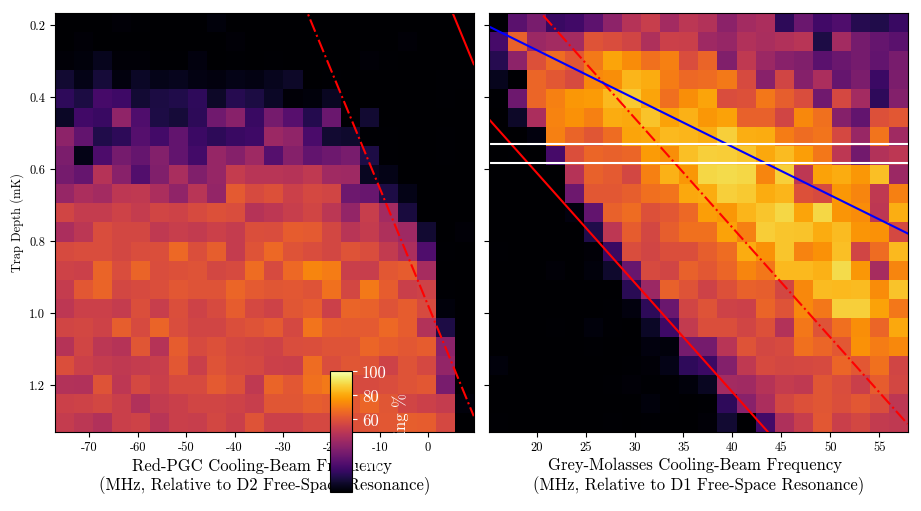

In [34]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

#cmap = customCm
cmap = 'inferno'
redImg = np.zeros((len(key1_r),len(key2_r)))
for i, keyVal in enumerate(key_red):
    i1 = np.where(key1_r==keyVal[0])[0][0]
    i2 = np.where(key2_r==keyVal[1])[0][0]
    redImg[i2,i1] = avg_combined_red[i]

greyImg = np.zeros((len(key1_g),len(key2_g)))
for i, keyVal in enumerate(key_grey):
    i1 = np.where(key1_g==keyVal[0])[0][0]
    i2 = np.where(key2_g==keyVal[1])[0][0]
    greyImg[i2,i1] = avg_combined_grey[i]

xKey_r = [misc.round_sig(MOT_DacToFreq.f(k)*1e-6) for k in key1_r]
yKey_r = [misc.round_sig(TweezerPowerToDepth.f(k)) for k in key2_r]

xKey_g = [misc.round_sig(D1_DacToFreq.f(k)) for k in key1_g]
yKey_g = [misc.round_sig(TweezerPowerToDepth.f(k)) for k in key2_g]

# mK per MHz
slope = 1 /( 20.8 + 9.86)
xpts = np.linspace(xKey_r[0], xKey_r[-1], 1000)

f = plt.figure(figsize=(20,10))
f.set_size_inches(11,11)
# as in plt.subplot(111)
ax = axesTool.ImageGrid(f, 111,
                     nrows_ncols=(1,2),
                     axes_pad=0.15 )
plt.sca(ax[0])
#plt.title('Standard Loading', y=1.1)
#plt.yticks(range(0,len(key2_r),2),[misc.round_sig(TweezerPowerToDepth.f(k)) for k in key2_r[::2]]);
#plt.xticks(range(0,len(key1_r),2),[misc.round_sig(MOT_DacToFreq.f(k)*1e-6) for k in key1_r[::2]], rotation=45);
plt.xlabel('Red-PGC Cooling-Beam Frequency \n(MHz, Relative to D2 Free-Space Resonance)',fontsize=12)

plt.sca(ax[1])
#plt.title('$\Lambda$-Enhanced Loading')
#plt.xticks(range(0,len(key1_g),2),[misc.round_sig(D1_DacToFreq.f(k)) for k in key1_g[::2]], rotation=45);
plt.xlabel('Grey-Molasses Cooling-Beam Frequency \n(MHz, Relative to D1 Free-Space Resonance)',fontsize=12)

ax[0].plot(xpts, linear.f(xpts, slope, 0), color='r', zorder=2 )
ax[0].plot(xpts, linear.f(xpts, slope, slope * 30), color='r', linestyle='-.', zorder=2 )
ax[0].set_ylabel('Trap Depth (mK)')
# 
slope = 1/(20.8 + 12.0)
slopeDepthDetuned = 1/(3 * 20.8 + 12.0)
xpts = np.linspace(xKey_g[0], xKey_g[-1], 1000)
ax[1].plot(xpts, linear.f(xpts, slope, 0), color='r', zorder=2 )
ax[1].plot(xpts, linear.f(xpts, slope, -slope*15), color='r', linestyle='-.', zorder=2 )
ax[1].plot(xpts, linear.f(xpts, slopeDepthDetuned, 0), color='b', linestyle='-',zorder=2 )
ax[1].axhline((yKey_g[6] + yKey_g[7]+0.01)/2,color='w')
ax[1].axhline((yKey_g[7] + yKey_g[8])/2,color='w')
ax[0].imshow( redImg*100, cmap=cmap, vmin=0, vmax=100, zorder=1,
              extent = [xKey_r[0],xKey_r[-1], yKey_r[-1],yKey_r[0]], 
              aspect=(xKey_r[-1]-xKey_r[0])/(yKey_r[-1]-yKey_r[0]) )
im = ax[1].imshow( greyImg * 100, cmap=cmap, vmin=0, vmax=100, zorder=1,
                   extent = [xKey_g[0],xKey_g[-1], yKey_g[-1],yKey_g[0]], 
                   aspect=(xKey_g[-1]-xKey_g[0])/(yKey_g[-1]-yKey_g[0]))
cbarax = inset_axes(ax[1],
                    width="5%",  # width = 10% of parent_bbox width
                    height="30%",  # height : 50%
                    bbox_to_anchor=(0, 0, 441, 402))
#cb = ax.cbar_axes[0].colorbar(im);
#cb.set_label_text( "Loading %", size=12 )
#cb.ax.xaxis.labelpad=-10
plt.colorbar(im, cax=cbarax)
cbarax.tick_params(axis='y', colors='w')
cbarax.set_yticklabels(np.arange(0,120,20),color='w',fontsize=12 )
cbarax.set_ylabel('Loading %',color='w', fontsize=12 )
plt.savefig( 'Single_Atom_Loading_Red_And_Grey.png', transparent=True, bbox_inches='tight', pad_inches=0.1, dpi=400)

# 100 Atoms

## Best Run

This run is from September 6th, some time after the initial runs. Its a long run so I think it's reasonably real, and it's the best long run I have

In [10]:
p = 0.80387
np.sqrt(p*(1-p)/(100*5000))

0.00056153899793335823

In [212]:
jeffreyInterval(0.80387,100*5000)

401935

(0.00056215860492370151, 0.00056094309111065499)

In [16]:
with exp.ExpFile('Sep_6_Grey_10x10_Loading_80_p_4.h5') as f:
    f.print_parameters()

 andorimagetime :20.0 
 cooling_time :200.0 
 d1__servo_value :0.213393988139 
 default795freq :0.0 
 defaultmotfreq :0.01 
 diagmot__servo_value :0.325698385348 
 field :3.0 
 fieldphi :1.5708 
 fieldtheta :1.5708 
 imagingdepth :199.0 
 imagingpower :0.3 
 imagingrepumppower :0.2 
 intrappgccoolingtime :10.0 
 loadingdepth :200.0 
 loadmottime :500.0 
 pushouttime :10.0 
 rerngdepth :200.0 
 sidemot__servo_value :0.185496918484 


In [ ]:
with exp.ExpFile('Sep_6_Grey_10x10_Loading_80_p_4.h5') as f:
    f.print_all()

Number of Pictures: 10000
Picture Dimensions: 25 x 23
Variaitons: 1
Repetitions: 5000
Experiment started at (H:M:S)  20:27:46:  on (Y-M-D) 2018-9-6


C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:785: OptimizeWarning:

Covariance of the parameters could not be estimated



Analyzing Variation... 0, [0.0035917401409344745]


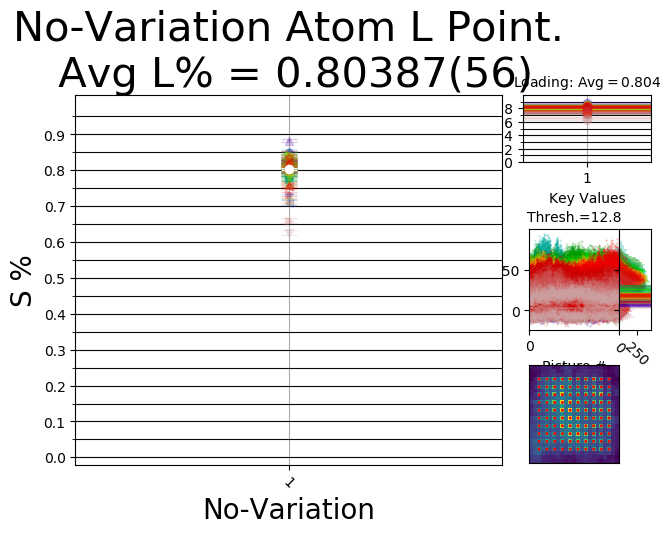

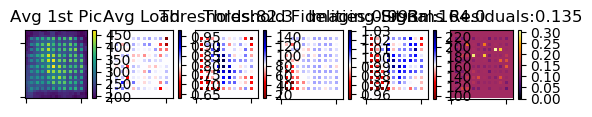

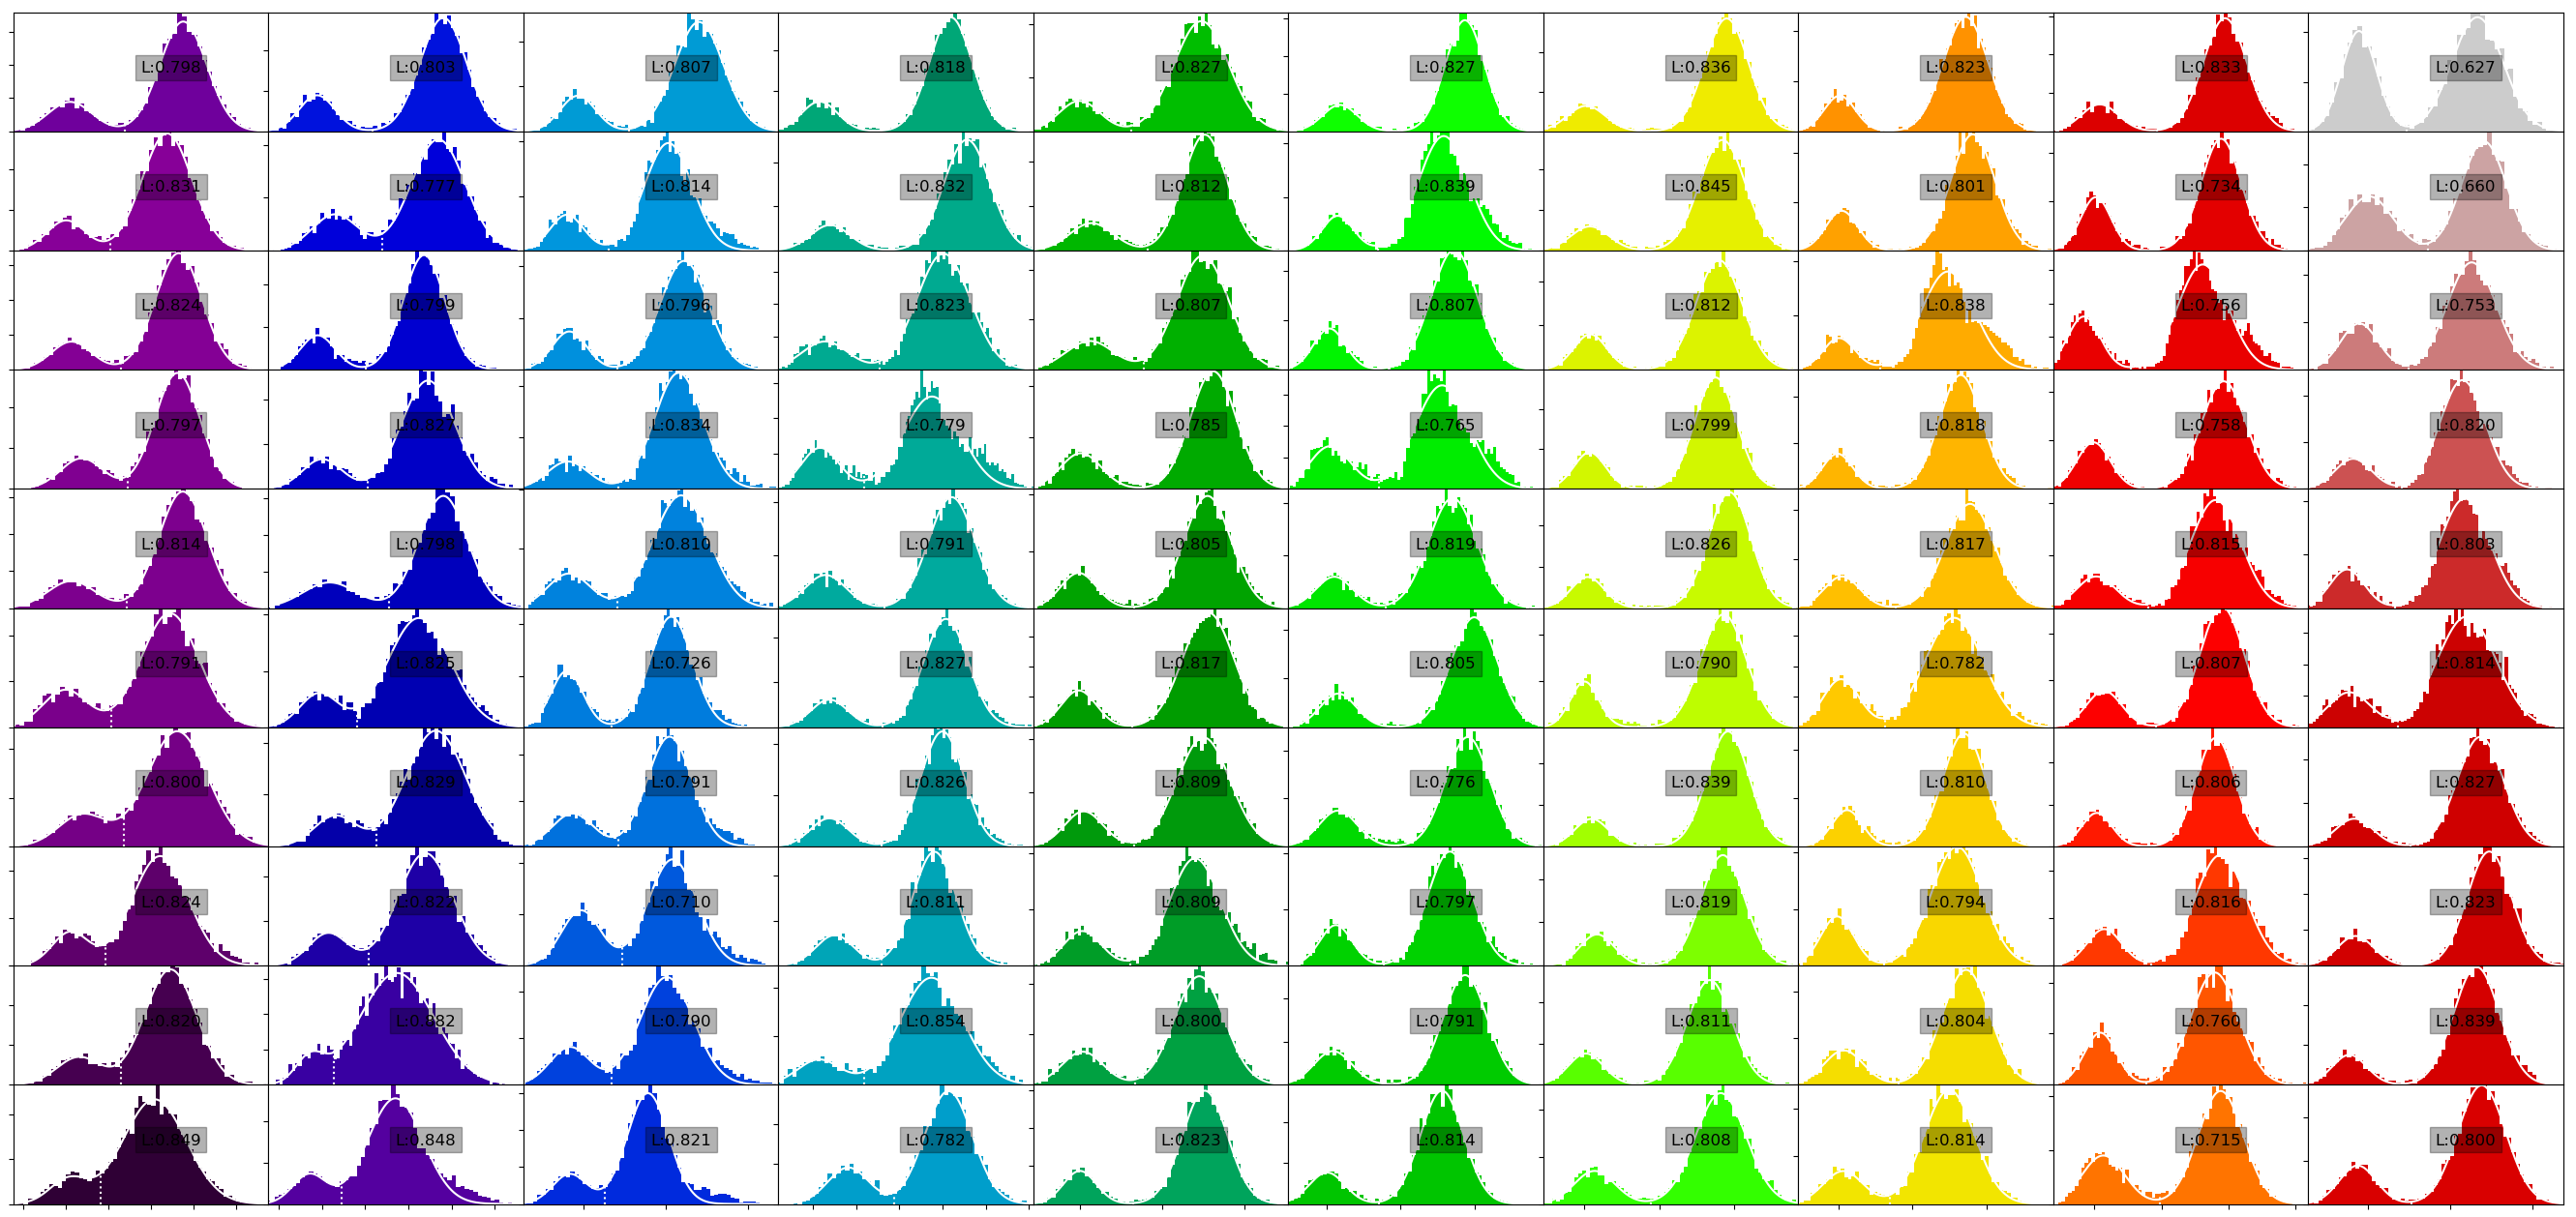

In [92]:
res = mp.Population('Sep_6_Grey_10x10_Loading_80_p_4.h5',[3,2,2,10,10],0,2, plotIndvHists=True);

In [71]:
TweezerPowerToDepth.f(1.8)

0.5981133162243657

In [100]:
thresholds = [T.t for T in res['Thresholds']]
fids = [T.fidelity for T in res['Thresholds']]

In [102]:
np.mean(fids)

0.9927973463528853

In [140]:
pics = res["Raw_Data"][::2]

The pictures weren't square, there was an extra border pixel in the vertical direction, so square it up.

In [141]:
pics_ = pics[:,1:24,:]

In [142]:
avgPic = np.zeros(pics_[0].shape)
for p in pics_:
    avgPic += p

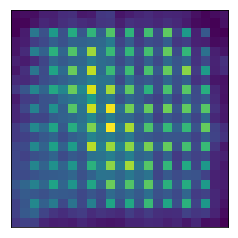

In [146]:
plt.imshow(avgPic,origin='bottom')
plt.xticks([])
plt.yticks([]);
plt.savefig('10x10_Atom_Image.png', transparent=True, bbox_inches='tight', pad_inches=0.1, dpi=400)

In [334]:
makeVid(pics_[50:150], '10x10_best.gif', 'gif', dur=0.15, vidMap=viridisMap, offset=100, maxMult=2, includeCount=False);

## single shot images

In [110]:
file = grey_mol_file_10x10
res = ma.standardPopulationAnalysis( file, [3,2,2,10,10], 0, 1, quiet=True, subtractEdges=False);
( fullPixelCounts, thresholds, avgPic, key, avgLoadingErr, avgLoading, allLoadingRate, allLoadingErr, loadFits,
  fitModule, keyName, totalAtomData, rawData, atomLocations, avgFits, atomImages, totalAvg, totalErr ) = res

48400 48400 484 hi


In [156]:
thresholds[0].t

231.65947117283207

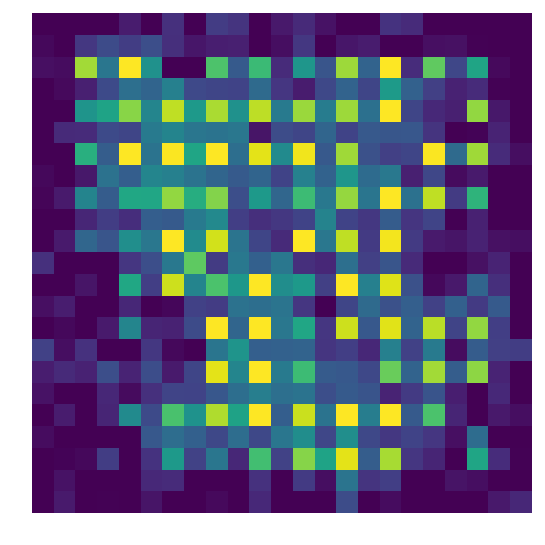

In [125]:
f = plt.figure(figsize=(5,5))
ax = plt.Axes(f, [0.,0.,1.,1.])
ax.set_axis_off()
f.add_axes(ax)
ax.imshow(rawData[5702][1:-1, :], vmin=200, vmax=450, origin='bottom', cmap='viridis')
plt.savefig('80_Atoms_.png', dpi=400)#, bbox_inches='tight', dpi=400)

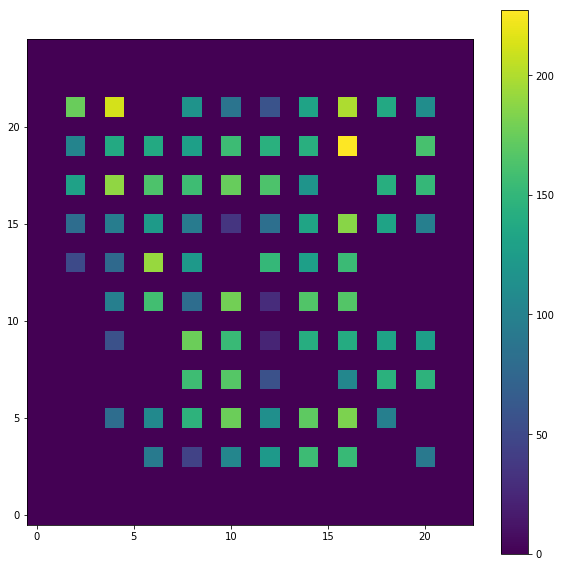

In [200]:
minv = 0
data = np.zeros((25,23)) + minv
plt.figure(figsize=(10,10))
for i, loc in enumerate(ah.unpackAtomLocations([3,2,2,10,10])):
    #print(thresholds[i].t)
    data[loc[0],loc[1]] = rawData[5702][loc[0],loc[1]]-thresholds[i].t - minv
plt.imshow(data, origin='bottom',vmin=minv)
plt.colorbar()


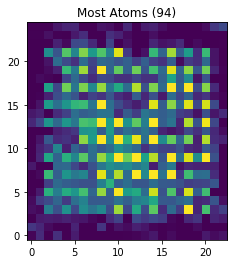

In [116]:
plt.title('Most Atoms (94)')
plt.imshow(rawData[np.argmax(atomNums)], origin='bottom', vmin=200, vmax=450)

In [117]:
atomNum80s = [i for i, x in enumerate(atomNums) if x == 80]

for index in atomNum80s[:100]:
    f, ax = plt.subplots(1,2)
    ax[0].imshow(rawData[index], vmin=200, vmax=400)
    ax[1].imshow(atomImages[index])
    plt.title(index)

## Detuning & Trap Depth Vs. Loading

### Raw Analysis

#### Main Data

In [ ]:
with exp.ExpFile(grey_mol_file_10x10) as f:
    f.print_all()

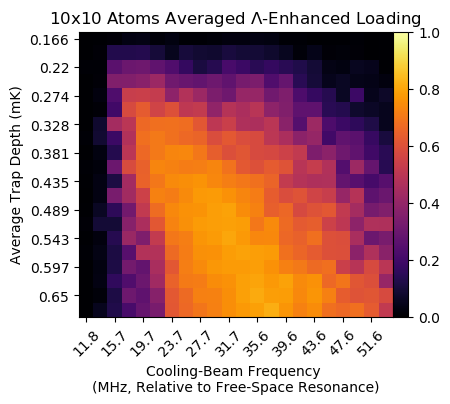

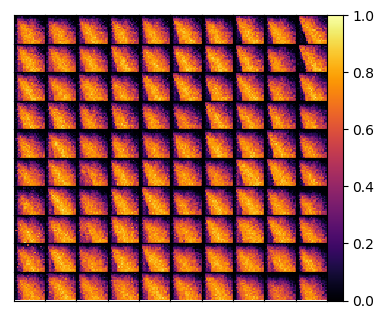

In [23]:
file = grey_mol_file_10x10
title = '10x10 Atoms Averaged $\Lambda$-Enhanced Loading'
controlUnits = False
showVals = False
realsize=False, 
save=False
key=None
data=None
err=None
res = ma.standardPopulationAnalysis( file, [3,2,2,10,10], 0, 1, quiet=True);
( _,_,_, key, avgLoadingErr, avgLoading, _, _, _,  _, _, _, _, _, _, _, _, _, ) = res
key1, key2 = key[:,0], key[:,1]
key1 = np.sort(np.unique(key1))
key2 = np.sort(np.unique(key2))
# we couldn't actually supply powers above ~205mw at this point,
# so the points beyond this are probably misleading.
key2 = [k for k in key2 if k <= 205]
avgAvgLoading = [np.mean(atmLoads) for atmLoads in misc.transpose(avgLoading)]
im_2dscan = np.zeros((len(key2),len(key1)))
f = plt.figure(figsize=(10,10))
if realsize:
    f.set_size_inches(4.25, 4.25)
for i, keyVal in enumerate(key):
    try:
        i1 = np.where(key1==keyVal[0])[0][0]
        i2 = np.where(key2==keyVal[1])[0][0]
    except IndexError:
        # happens when the loop finds a key with a power that is being discarded.
        continue
    im_2dscan[i2,i1] = avgAvgLoading[i]
    if showVals:
        text(i1-0.5, i2+0.25, misc.round_sig(avgAvgLoading[i], 2), fontsize=8, color='g')

im = plt.imshow(im_2dscan, cmap='inferno', vmin=0, vmax=1)
plt.grid(False)
plt.xlabel('Cooling-Beam Frequency \n(MHz, Relative to Free-Space Resonance)')
plt.ylabel('Average Trap Depth (mK)')
if controlUnits:
    xticks(range(0, len(key1), 2),[misc.round_sig(k) for k in key1[::2]], rotation=50)
    yticks(range(0, len(key2), 2),[misc.round_sig(k) for k in key2[::2]])
else:
    plt.xticks(range(0, len(key1), 2),[misc.round_sig(D1_DacToFreq.f(k)) for k in key1[::2]],rotation=45);
    plt.yticks(range(0, len(key2), 2),[misc.round_sig(TweezerPowerToDepth.f(k/100)) for k in key2[::2]]);

plt.title(title)
divider = axesTool.make_axes_locatable(plt.gca())
cax = divider.append_axes('right', size='5%', pad=0.0)
f.colorbar(im, cax, orientation='vertical');
if save:
    plt.savefig('Raw_10x10.png', transparent=True, bbox_inches='tight', pad_inches=0.1)
# indv atom fig
fig = plt.figure(figsize=(20,20))
if realsize:
    fig.set_size_inches(4.25, 4.25)
grid = axesTool.AxesGrid( fig, 111, nrows_ncols=(10, 10), axes_pad=0.0, share_all=True,
                          label_mode="L", cbar_location="right", cbar_mode="single" )
for atomInc in range(100):
    num = 100 - 10*((atomInc % 10)+1) + atomInc // 10
    ax = grid[num]
    im_2dscan = np.zeros((len(key2),len(key1)))
    for i, keyVal in enumerate(key):
        try:            
            i1 = np.where(key1==keyVal[0])[0][0]
            i2 = np.where(key2==keyVal[1])[0][0]
        except IndexError:
            # happens when the loop finds a key with a power that is being discarded.
            continue
        im_2dscan[i2,i1] = avgLoading[atomInc][i]
    ax.grid(False)
    plt.sca(ax)
    plt.xticks([],[])
    plt.yticks([],[])
    ax.axis('on')
    im = ax.imshow(im_2dscan, cmap='inferno', vmin=0, vmax=1)
    ax.grid(False)
grid.cbar_axes[0].colorbar(im);
if save:
    pass

#### Max Loading for each atom

Mean Maximum Loading Value: 0.8898


Text(0.5,1,'Max loading for each atom')

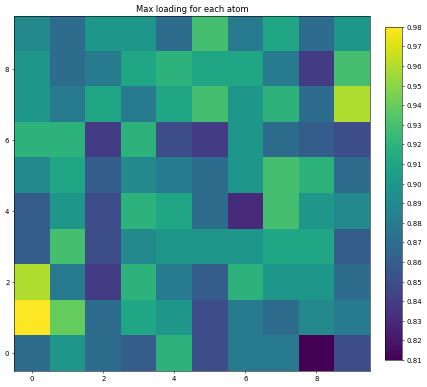

In [25]:
maxData = []
for atomLoc in range(100):
    maxData.append(max(avgLoading[atomLoc]))
maxData = [maxData[i] if maxData[i] is not None else np.mean([i for i in maxData if i is not None]) for i in range(len(maxData))] 
print('Mean Maximum Loading Value:', np.mean(maxData))
key1, key2 = key[:,0], key[:,1]
key1 = np.sort(np.unique(key1))
key2 = np.sort(np.unique(key2))
plt.figure(figsize=(10,10), dpi=50)
im = plt.imshow(misc.transpose(np.reshape(maxData,(10,10))), origin='bottom')
cb = plt.colorbar(im, ax=plt.gca(),fraction=0.043, pad=0.04)
tick_locator = ticker.MaxNLocator(nbins=20)
cb.locator = tick_locator
cb.update_ticks()
plt.title('Max loading for each atom')

### Optimizing Thresholds

#### Main Data

even binning so the mean works

In [123]:
avgFid = 0
for i, tbin in enumerate(thresholdsData):
    for atom in tbin:
        weight = borders[i+1] - borders[i]
        avgFid += atom.fidelity * weight
avgFid /= 484*100

In [124]:
avgFid

0.99886977962184598

In [111]:
fidList = [atom.fidelity for b in thresholdsData for atom in b]

In [113]:
np.mean(fidList)

0.99886750785129008

In [105]:
file = grey_mol_file_10x10
title = '10x10 Atoms Averaged $\Lambda$-Enhanced Loading'
controlUnits = False
showVals = False
realsize=False, 
save=True
key=None
data=None
err=None
thresholdsData=[]
repsPerVar = 100
borders = [int(x) for x in np.linspace(0,484,20)]
errs, pixels, thresh, data = [[[None for _ in range(len(borders)-1)] for _ in range(100)] for _ in range(4)]
print('Collecting Data & sorting through borders...',end='')
for bi in range(len(borders)-1):
    print('.',end='')
    begin, end = borders[bi:bi+2]
    res = ma.standardPopulationAnalysis(file, [3,2,2,10,10], 0, 1, dataRange=np.arange(begin,end),
                                        picSlice=[begin*repsPerVar,repsPerVar*end], quiet=True);
    thresholdsData.append(res[1])
    for ai in range(100):
        errs[ai][bi], thresh[ai][bi], pixels[ai][bi], data[ai][bi] = res[4][ai], res[1][ai], res[0][ai], res[5][ai]
print('.')
with exp.ExpFile(file) as f:
    kn, key_10 = f.get_key()
key1_10, key2_10 = key_10[:,0], key_10[:,1]
key1_10 = np.sort(np.unique(key1_10))
key2_10 = np.sort(np.unique(key2_10))
# we couldn't actually supply powers above ~205mw at this point,
# so the points beyond this are probably misleading.
key2_10 = [k for k in key2_10 if k <= 190]
# unitful
xKey_10 = [misc.round_sig(D1_DacToFreq.f(k)) for k in key1_10]
yKey_10 = [misc.round_sig(TweezerPowerToDepth.f(k)/100) for k in key2_10]

optData = [[] for _ in range(100)]
for atomInc in range(100):
    for borderInc in range(len(data[atomInc])):
        optData[atomInc] += data[atomInc][borderInc]
# (To see (kinda) where the threshold regions are)
#figure(figsize=(20,5))
#for ai in range(100):
#    x_i = 0
#    for p, t in zip(pixels[ai], thresh[ai]):
#        plot(np.arange(x_i, x_i + len(p)), p, '.', markersize=1)
#        hlines(t, xmin=x_i, xmax=x_i + len(p), color='k')
#        x_i += len(p)
avgAvgLoading = [np.mean(atmLoads) for atmLoads in misc.transpose(optData)]
im_2dscan = np.zeros((len(key2_10),len(key1_10)))
for i, keyVal in enumerate(key_10):
    try:
        i1 = np.where(key1_10==keyVal[0])[0][0]
        i2 = np.where(key2_10==keyVal[1])[0][0]
    except IndexError:
        # happens when the loop finds a key with a power that is being discarded.
        continue
    im_2dscan[i2,i1] = avgAvgLoading[i]
    if showVals:
        plt.text(i1-0.5, i2+0.25, misc.round_sig(avgAvgLoading[i], 2), fontsize=8, color='g')

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:785: OptimizeWarning:

Covariance of the parameters could not be estimated



................


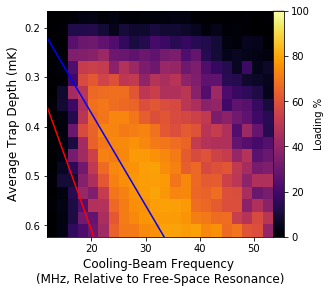

In [135]:
f = plt.figure(figsize=(10,10))
f.set_size_inches(4.25,4.25)
grid = axesTool.AxesGrid( f, 111, nrows_ncols=(1, 1), axes_pad=0.0, share_all=True,
                          label_mode="L", cbar_location="right", cbar_mode="single" )
grid[0].imshow( im_2dscan, cmap='inferno', vmin=0, vmax=1,
                extent = [xKey_10[0],xKey_10[-1], yKey_10[-1],yKey_10[0]],
                aspect=(xKey_10[-1]-xKey_10[0])/(yKey_10[-1]-yKey_10[0]))

# this is MHz per mK, need to convert to vertical pixel per horizontal pixel (vp per hp)
slope = 1/(20.8 + 12.0)
slopeDepthDetuned = 1/(2 * 20.8 + 12.0)
xpts = np.linspace(xKey_10[0], xKey_10[-1], 1000)
grid[0].plot(xpts, linear.f(xpts, slope, 0), color='r', zorder=2 )
grid[0].plot(xpts, linear.f(xpts, slopeDepthDetuned, 0), color='b', zorder=2 )

plt.grid(False)
grid[0].set_xlabel('Cooling-Beam Frequency \n(MHz, Relative to Free-Space Resonance)',fontsize=paper_Font_Size)
grid[0].set_ylabel('Average Trap Depth (mK)',fontsize=paper_Font_Size)
grid[0].set_xlim(xKey_10[0], xKey_10[-1])
grid[0].set_ylim(yKey_10[-1],yKey_10[0]);
cb = grid.cbar_axes[0].colorbar(im);
axis = grid.cbar_axes[0].axis['right']
axis.label.set_text("Loading %")

plt.savefig('10x10_Lambda_Loading_2D_Scan.png', transparent=True, bbox_inches='tight', pad_inches=0.1, dpi=400)


#### Version for combining with grey loading

It's not trivial to get the aspects exactly correct using subplots, (seems like the best option would be to use gridspec, but I'm liking AxesTool), so instead just make two plots that can be combined separately.

In [342]:
with exp.ExpFile(grey_mol_file) as f:
    kn, key_1 = f.get_key()
key1_1, key2_1 = key_1[:,0], key_1[:,1]
key1_1 = np.sort(np.unique(key1_1))
key2_1 = np.sort(np.unique(key2_1))
yKey_1 = [misc.round_sig(TweezerPowerToDepth.f(k)) for k in key2_1]
squishRatio = ((yKey_1[-1] - yKey_1[0])/(yKey_10[-1]-yKey_10[0]))**-1

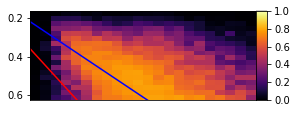

In [343]:
f = plt.figure(figsize=(10,10))
f.set_size_inches(4.25,4.25)
grid = axesTool.AxesGrid( f, 111, nrows_ncols=(1, 1), axes_pad=0.0, share_all=True,
                          label_mode="L", cbar_location="right", cbar_mode="single" )
grid[0].imshow(im_2dscan, cmap='inferno', vmin=0, vmax=1,
                extent = [xKey_10[0],xKey_10[-1], yKey_10[-1],yKey_10[0]],
               aspect=(xKey_10[-1]-xKey_10[0])/(yKey_10[-1]-yKey_10[0]) * squishRatio)

# this is MHz per mK, need to convert to vertical pixel per horizontal pixel (vp per hp)
slope = 1/(20.8 + 12.0)
slopeDepthDetuned = 1/(2 * 20.8 + 12.0)
xpts = np.linspace(xKey_10[0], xKey_10[-1], 1000)
grid[0].plot(xpts, linear.f(xpts, slope, 0), color='r', zorder=2 )
grid[0].plot(xpts, linear.f(xpts, slopeDepthDetuned, 0), color='b', zorder=2 )

plt.grid(False)
#grid[0].set_xlabel('Cooling-Beam Frequency \n(MHz, Rel. to Free-Space Resonance)',fontsize=paper_Font_Size)
#grid[0].set_ylabel('Avg Depth (mK)',fontsize=paper_Font_Size)
grid[0].set_xlim(xKey_10[0], xKey_10[-1])
grid[0].set_ylim(yKey_10[-1],yKey_10[0]);
cb = grid.cbar_axes[0].colorbar(im);
grid[0].set_xticks([])
plt.savefig('10x10_Lambda_Loading_2D_Scan_squish.png', transparent=True, bbox_inches='tight', pad_inches=0.1,dpi=400)


#### indv atoms

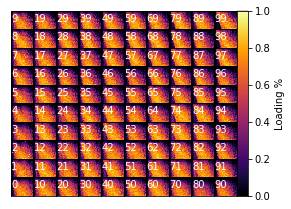

In [344]:
# ### Indv Atoms
fig = plt.figure(figsize=(10,10))
fig.set_size_inches(4.25, 4.25)
grid = axesTool.AxesGrid( fig, 111, nrows_ncols=(10, 10), axes_pad=0.0, share_all=True,
                          label_mode="L", cbar_location="right", cbar_mode="single" )
for atomInc in range(100):
    num = 100 - 10*((atomInc % 10)+1) + atomInc // 10
    ax = grid[num]
    im_2dscan = np.zeros((len(key2_10),len(key1_10)))
    for i, keyVal in enumerate(key_10):
        try:
            i1 = np.where(key1_10==keyVal[0])[0][0]
            i2 = np.where(key2_10==keyVal[1])[0][0]
        except IndexError:
            # happens when the loop finds a key with a power that is being discarded.
            continue
        im_2dscan[i2,i1] = optData[atomInc][i]
    ax.grid(False)
    plt.sca(ax)
    plt.xticks([],[])
    plt.yticks([],[])
    ax.axis('on')
    im = ax.imshow(im_2dscan, cmap='inferno', vmin=0, vmax=1)
    ax.grid(False)
    ax.text(0,10,atomInc,color='w')
cb = grid.cbar_axes[0].colorbar(im);
axis = grid.cbar_axes[0].axis['right']
axis.label.set_text("Loading %")
if save:
    plt.savefig('10x10_Individual_Atoms_Grey_Molasses.png', transparent=True, bbox_inches='tight', pad_inches=0.1, dpi=400);

# used for single atom grey and red loading scans
def single_atom_analysis_(file, title, units = None, showVals = False, realsize=False, save=False, key=None, data=None, err=None):
    if file is not None:
        res = ma.standardPopulationAnalysis( file, [[2,2]], 0, 1, quiet=True );
        ( _, _, _, key, avgLoadingErr, avgLoading, _, _, _, _, _, _, _, _, _, _,_,_ ) = res
        avgLoading = avgLoading[0]
        avgLoadingErr = avgLoadingErr[0]
    else:
        avgLoading = data
        avgLoadingErr = err
    key1, key2 = key[:,0], key[:,1]
    key1 = np.sort(np.unique(key1))
    key2 = np.sort(np.unique(key2))
    im_2dscan = np.zeros((len(key1),len(key2)))
    f = plt.figure(figsize=(10,10))
    if realsize:
        f.set_size_inches(4.25, 4.25)
    for i, keyVal in enumerate(key):
        i1 = np.where(key1==keyVal[0])[0][0]
        i2 = np.where(key2==keyVal[1])[0][0]
        im_2dscan[i2,i1] = avgLoading[i]
        if showVals:
            plt.text(i1-0.5, i2+0.25, misc.round_sig(avgLoading[i],2), fontsize=6, color='g')
            plt.text(i1-0.5, i2-0.25, misc.round_sig(avgLoadingErr[i],2), fontsize=6, color='g')
    if units is None:
        xKey = [misc.round_sig(k) for k in key1]
        yKey = [misc.round_sig(k) for k in key2]
    elif units == "red":
        xKey = [misc.round_sig(MOT_DacToFreq.f(k)*1e-6) for k in key1]
        yKey = [misc.round_sig(TweezerPowerToDepth.f(k)) for k in key2]
    elif units == "grey":
        xKey = [misc.round_sig(D1_DacToFreq.f(k)) for k in key1]
        yKey = [misc.round_sig(TweezerPowerToDepth.f(k)) for k in key2]

    im = plt.imshow(im_2dscan, cmap='inferno', vmin=0, vmax=1, zorder=1,
                    extent = [xKey[0],xKey[-1], yKey[-1],yKey[0]], aspect=(xKey[-1]-xKey[0])/(yKey[-1]-yKey[0]))
    if units == "red":
        # this is MHz per mK, need to convert to vertical pixel per horizontal pixel (vp per hp)
        slope = 1 /( 20.8 + 9.86)
        xpts = np.linspace(xKey[0], xKey[-1], 1000)
        plt.plot(xpts, linear.f(xpts, slope, 0), color='r', zorder=2 )
    if units == "grey":
        # this is MHz per mK, need to convert to vertical pixel per horizontal pixel (vp per hp)
        slope = 1/(20.8 + 12.0)
        slopeDepthDetuned = 1/(2 * 20.8 + 12.0)
        xpts = np.linspace(xKey[0], xKey[-1], 1000)
        plt.plot(xpts, linear.f(xpts, slope, 0), color='r', zorder=2 )
        plt.plot(xpts, linear.f(xpts, slopeDepthDetuned, 0), color='b', zorder=2 )
    
    #plt.xticks(range(0,len(key1),2), xKey, rotation=25);
    #plt.yticks(range(0,len(key2),2), yKey);

    plt.grid(False)
    plt.xlabel('Cooling-Beam Frequency \n(MHz, Relative to Free-space resonance)', color=textColor)
    plt.ylabel('Trap Depth (mK)', color=textColor)
    plt.xlim(xKey[0], xKey[-1])
    plt.ylim(yKey[-1],yKey[0]);
    """
    divider = axesTool.make_axes_locatable(plt.gca())
    cax = divider.append_axes('right', size='5%', pad=0.0)
    cb = f.colorbar(im, cax, orientation='vertical');
    cb.ax.set_ylabel('Loading %', fontsize=paper_Font_Size)
    plt.title(title)
    """
    if save:
        plt.savefig(title + '.png', transparent=True, bbox_inches='tight', pad_inches=0.1, dpi=400)


### Histogram

In [136]:
arr(optData)[0]

array([ 0.73,  0.01,  0.33,  0.  ,  0.61,  0.33,  0.43,  0.74,  0.42,
        0.06,  0.78,  0.7 ,  0.09,  0.45,  0.65,  0.42,  0.04,  0.56,
        0.84,  0.02,  0.61,  0.76,  0.05,  0.  ,  0.64,  0.04,  0.31,
        0.76,  0.79,  0.67,  0.45,  0.01,  0.21,  0.2 ,  0.11,  0.78,
        0.49,  0.54,  0.02,  0.37,  0.27,  0.61,  0.02,  0.13,  0.78,
        0.7 ,  0.48,  0.01,  0.64,  0.35,  0.7 ,  0.81,  0.64,  0.45,
        0.49,  0.51,  0.6 ,  0.73,  0.28,  0.11,  0.01,  0.78,  0.44,
        0.44,  0.69,  0.71,  0.45,  0.31,  0.33,  0.05,  0.34,  0.01,
        0.14,  0.01,  0.13,  0.76,  0.74,  0.03,  0.48,  0.8 ,  0.67,
        0.44,  0.74,  0.2 ,  0.72,  0.38,  0.81,  0.16,  0.09,  0.01,
        0.71,  0.76,  0.38,  0.7 ,  0.66,  0.86,  0.81,  0.66,  0.77,
        0.02,  0.35,  0.71,  0.36,  0.69,  0.07,  0.77,  0.05,  0.2 ,
        0.8 ,  0.06,  0.14,  0.73,  0.07,  0.4 ,  0.81,  0.75,  0.31,
        0.65,  0.58,  0.79,  0.73,  0.47,  0.01,  0.49,  0.13,  0.57,
        0.05,  0.06,

In [137]:
histData = [[[None] for _ in range(22)] for _ in range(20)]
for i, keyVal in enumerate(key_10):
    try:
        i1 = np.where(key1==keyVal[0])[0][0]
        i2 = np.where(key2==keyVal[1])[0][0]
    except IndexError:
        # happens when the loop finds a key with a power that is being discarded.
        continue
    histData[i2][i1] = arr(optData)[:,i]*100

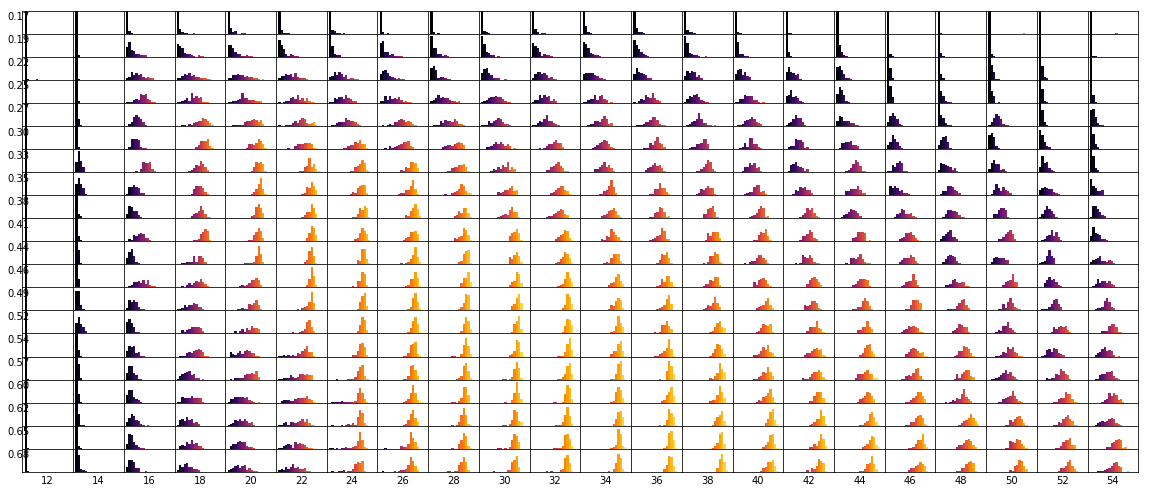

In [138]:
fig = plt.figure(figsize=(20,20))
inf = plt.get_cmap('inferno', 20)
grid = axesTool.AxesGrid( fig, 111, nrows_ncols=(20, 22), axes_pad=0.0, share_all=True)
                          #label_mode="L", cbar_location="right", cbar_mode="single" )
gridgrid = np.reshape(grid, (20,22))
for i, keyVal in enumerate(key_10):
    try:
        i1 = np.where(key1==keyVal[0])[0][0]
        i2 = np.where(key2==keyVal[1])[0][0]
    except IndexError:
        # happens when the loop finds a key with a power that is being discarded.
        continue
    a = gridgrid[i2][i1]
    # histData = arr(optData)[:,i]*100
    N3, bins, patches = a.hist(histData[i2][i1], bins=np.arange(0,105,5))
    a.set_ylim(0,50)
    plt.sca(a)
    plt.xticks([],[])
    plt.yticks([],[])
    a.set_xlabel(misc.round_sig_str(D1_DacToFreq.f(keyVal[0]),2))
    a.set_ylabel(misc.round_sig_str(TweezerPowerToDepth.f(keyVal[1])/100,2), rotation=0)
    for k in range(len(patches)):
        patches[k].set_facecolor(inf(k))

In [394]:
arr(histData).shape

(20, 22, 100)

In [396]:
yKey_10[14]

0.54300000000000004

In [467]:
inf = plt.get_cmap('inferno', 20)

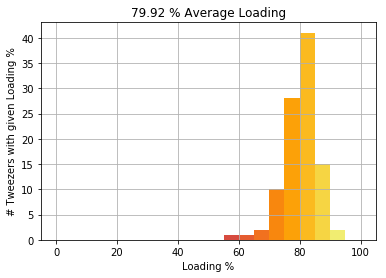

In [469]:
which = 10
wr = 14
N3, bins, patches = plt.hist(histData[wr][which], bins=np.arange(0,105,5))
plt.title(str(np.mean(histData[wr][which])) + ' % Average Loading')
plt.xlabel('Loading %')
plt.grid(True)
plt.ylabel('# Tweezers with given Loading %')
for k in range(len(patches)):
    patches[k].set_facecolor(inf(k))
#plt.savefig('Single_Hist_Example.png', transparent=True, bbox_inches='tight', pad_inches=0.1, dpi=400)

#### Max Loading for each atom

In [ ]:
maxData = []
for atomLoc in range(100):
    maxData.append(max(avgLoading[atomLoc]))
maxData = [maxData[i] if maxData[i] is not None else np.mean([i for i in maxData if i is not None]) for i in range(len(maxData))] 
print("Mean Atom's Maximum Loading:", np.mean(maxData))
key1, key2 = key[:,0], key[:,1]
key1 = np.sort(np.unique(key1))
key2 = np.sort(np.unique(key2))
plt.figure(figsize=(10,10), dpi=50)
im = plt.imshow(misc.transpose(np.reshape(maxData,(10,10))), origin='bottom')
cb = plt.colorbar(im, ax=plt.gca(),fraction=0.043, pad=0.04)
tick_locator = ticker.MaxNLocator(nbins=20)
cb.locator = tick_locator
cb.update_ticks()
plt.title('Max loading for each atom');

# Tweezer Videos

In [336]:
reloadMyModules()

In [337]:
pics_static = ah.loadCompoundBasler('AceData_Static_10x10.txt')
pics_ramp = ah.loadCompoundBasler('AceData_RampDown.txt')
pics_move = ah.loadCompoundBasler('AceData_Move.txt')

KeyboardInterrupt: 

In [ ]:
pics_static_avg = [np.zeros(pics_static[0].shape) for _ in range(3)]
for i, pic in enumerate(pics_static):
    pics_static_avg[i//10] += pic

In [ ]:
pics_ramp_avg = [np.zeros(pics_ramp[0].shape) for _ in range(101)]
for i, pic in enumerate(pics_ramp):
    pics_ramp_avg[i//10] += pic

In [ ]:
pics_move_avg = [np.zeros(pics_move[0].shape) for _ in range(101)]
for i, pic in enumerate(pics_move):
    pics_move_avg[i//10] += pic

In [ ]:
allPics = pics_ramp_avg + pics_move_avg

In [ ]:
makeVid(arr(allPics), "TweezerMove.gif", "gif", dur=0.02, includeCount=False, vidMap=magmaMap,resolutionMult=1)